In [1]:
%load_ext autoreload
%autoreload 2

# import intake
import numpy as np
import netCDF4 as nc
import xarray as xr
import os
from matplotlib import pyplot as plt
#import xesmf as xe
import pandas as pd
import pickle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# import matplotlib.ticker as mticker
# from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#from gfdl_grid_paper import *
import momlevel
import glob
#import cf_xarray as cfxr
from scipy.interpolate import griddata

In [2]:
inputdir='/glade/work/clittle/p2521/input/'
inputdir2='/glade/work/clittle/p2521/'
modeldir='model/'
# ds_grid = xr.open_dataset(inputdir+modeldir+'ESM4_ocean_static.nc')
# ds_grid_esm4=ds_grid[['geolon','geolat','geolon_c','geolat_c','wet','areacello', 'deptho']]

In [3]:
tgcsvin = './tg_locs_gs.csv'
# temp

In [4]:
margin = 2

def cutdomain(ds, margin):
    # Common variations of latitude and longitude names
    latitude_names = ['lat', 'latitude', 'Latitude', 'LAT', 'nav_lat']
    longitude_names = ['lon', 'longitude', 'Longitude', 'LON', 'nav_lon']

    #latitude_names = ds.cf.coordinates['latitude'][0]
    #longitude_names = ds.cf.coordinates['longitude'][0]

    # Identify the latitude and longitude coordinate names in the dataset
    lat_name = next((name for name in latitude_names if name in ds.coords), None)
    lon_name = next((name for name in longitude_names if name in ds.coords), None)

    if lat_name is None or lon_name is None:
        raise ValueError("Latitude or longitude coordinate not found in the dataset.")
   
    # Ensure that latitude and longitude arrays are computed before using them for indexing
    ds[lat_name] = ds[lat_name].compute()
    ds[lon_name] = ds[lon_name].compute()

    # Apply the margin-based conditions using the detected latitude and longitude names
    ds = ds.where(ds[lat_name] < max_lat + margin, drop=True)
    ds = ds.where(ds[lat_name] > min_lat - margin, drop=True)
    ds = ds.where(ds[lon_name] < max_lon + margin, drop=True)
    ds = ds.where(ds[lon_name] > min_lon - margin, drop=True)

    return ds

In [5]:
def model_dim_check(ds):
    if 'j' not in list(ds.dims):
        ds = ds.rename({'y':'j', 'x':'i','lat':'latitude', 'lon':'longitude'})#.drop(#['lon']#=ds_grid.geolon.values
        
    if 'lat_bnds' in list(ds.keys()):
        ds = ds.rename({'lat_bnds':'vertices_latitude', 'lon_bnds':'vertices_longitude', 'vertex':'vertices'})#.drop(#['lon']#=ds_grid.geolon.values

    if 'bounds_lat' in list(ds.keys()):
        ds = ds.rename({'bounds_lat':'vertices_latitude', 'bounds_lon':'vertices_longitude', 'nvertex':'vertices'})#.drop(#['lon']#=ds_grid.geolon.values
        
    # Common variations of latitude and longitude names
    latitude_names = ['lat', 'latitude', 'Latitude', 'LAT', 'nav_lat']
    longitude_names = ['lon', 'longitude', 'Longitude', 'LON', 'nav_lon']

    #latitude_names = ds.cf.coordinates['latitude'][0]
    #longitude_names = ds.cf.coordinates['longitude'][0]

    # Identify the latitude and longitude coordinate names in the dataset
    lat_name = next((name for name in latitude_names if name in ds.coords), None)
    lon_name = next((name for name in longitude_names if name in ds.coords), None)
    
    if ds.sizes['i'] > ds.sizes['j']:
        print('i dimension is larger than j dimension. Therefore, dimension names need to be swapped')
        ds = ds.rename({'i':'i_temp', 'j':'j_temp'})
        ds = ds.rename({'i_temp':'j', 'j_temp':'i'})
        print('dimension names swapped')

    else:
        #ds.sizes['i'] < ds.sizes['j']
        print('no swapping of i and j dimensions')

    if ds[lon_name].min() < 0:
        print('longitude ranges from -180 to 180. This needs to be changed as 0 to 360')
        temp = ds[lon_name]
        temp = (temp+360)%360
        ds = ds.drop_vars('longitude')
        ds = ds.assign_coords(longitude=(['i', 'j'], temp.data))
        print('longitude values changed')

    return(ds)

In [6]:
%%time
# Define available models
mods = [
    #"DTU22",
    "CNRM-CM6-1",
    "CNRM-CM6-1-HR",
    "EC-Earth3P",
    "EC-Earth3P-HR",
    "GFDL-ESM4",
    "GFDL-CM4",
    "HadGEM3-GC31-LL",
    "HadGEM3-GC31-MM",
    "HadGEM3-GC31-HM",
    "ECMWF-IFS-LR",
    "ECMWF-IFS-MR",
    "ECMWF-IFS-HR",
    # "CMCC-CM2-HR4",
    # "CMCC-CM2-VHR4",
    # "HadGEM3-GC31-HH"
]
ds_models_zos=[]
source_ids = mods#[4:6]
for i in range(len(source_ids)):
    source_id=source_ids[i]
    if (source_id=="DTU22"):
        ds_zos = xr.open_dataset("/glade/work/clittle/p2521/input/obs/dtuuh22mdt.nc")
    else:
        if (source_id=="GFDL-ESM4") or (source_id=="GFDL-CM4"):
            ds_zos = xr.open_mfdataset(inputdir2+'zos_Omon_'+source_id+'*.nc')
            ds_zos = ds_zos.rename({'y':'j', 'x':'i','lat':'latitude', 'lon':'longitude'})#.drop(#['lon']#=ds_grid.geolon.values
        else:
            filepath = f'/glade/work/netige/Data/CMIP6_Downloader/data/s_{source_id}_e_hist-1950_vl_r1i*_f_mon_v_zos/'
            ds_zos_flist1 = sorted(glob.glob(filepath+f'/zos_Omon_{source_id}_hist-1950_r1i*_gn_199*.nc'))
            ds_zos_flist2 = sorted(glob.glob(filepath+f'/zos_Omon_{source_id}_hist-1950_r1i*_gn_200*.nc'))#[0-9].nc'))
            ds_zos_flist3 = sorted(glob.glob(filepath+f'/zos_Omon_{source_id}_hist-1950_r1i*_gn_201*.nc'))
            ds_zos_flist4 = sorted(glob.glob(filepath+f'/zos_Omon_{source_id}_hist-1950_r1i*_gn_202*.nc'))
            ds_zos_flist = (ds_zos_flist1+ds_zos_flist2+ds_zos_flist3+ds_zos_flist4)
            ds_zos = xr.open_mfdataset(ds_zos_flist)        # print(i)
        
    # #Check if model dimensions are compatible to run cutdomain. If not modify model dimensions
        ds_zos = model_dim_check(ds_zos)
    
    # #Select region of interest IF regridding
    min_lon = 260
    max_lon = 320
    min_lat = 15
    max_lat = 60
    min_lon = 260
    max_lon = 360
    min_lat = 15
    max_lat = 75
    # max_lat = 20
    ds_zos= cutdomain(ds_zos, margin)

    if (source_id=="DTU22"):
        ds_model = ds_zos.rename({'mdt':'zos'}).drop_vars('err_mdt')
    else:
        ds_model_zos = ds_zos.sel(time=slice('1993-01', '2014-12'))

    # Append to list
    ds_models_zos.append(ds_model_zos)
        #ds_model=ds_model.mean(dim='year').compute()   
    #ds_models.append(ds_model)
    print('Done with ' + source_ids[i])
# ds_models

<timed exec>:37: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


i dimension is larger than j dimension. Therefore, dimension names need to be swapped
dimension names swapped
longitude ranges from -180 to 180. This needs to be changed as 0 to 360
longitude values changed
Done with CNRM-CM6-1


<timed exec>:37: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
/glade/u/home/netige/miniconda3/envs/_MDTF_python3_base/lib/python3.12/site-packages/xarray/core/indexing.py:1814: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/glade/u/home/netige/miniconda3/envs/_MDTF_pyth

i dimension is larger than j dimension. Therefore, dimension names need to be swapped
dimension names swapped
longitude ranges from -180 to 180. This needs to be changed as 0 to 360
longitude values changed
Done with CNRM-CM6-1-HR


<timed exec>:37: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


i dimension is larger than j dimension. Therefore, dimension names need to be swapped
dimension names swapped
Done with EC-Earth3P


<timed exec>:37: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


i dimension is larger than j dimension. Therefore, dimension names need to be swapped
dimension names swapped
Done with EC-Earth3P-HR


<timed exec>:28: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


i dimension is larger than j dimension. Therefore, dimension names need to be swapped
dimension names swapped
longitude ranges from -180 to 180. This needs to be changed as 0 to 360
longitude values changed
Done with GFDL-ESM4


<timed exec>:28: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


i dimension is larger than j dimension. Therefore, dimension names need to be swapped
dimension names swapped
longitude ranges from -180 to 180. This needs to be changed as 0 to 360
longitude values changed
Done with GFDL-CM4


<timed exec>:37: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


i dimension is larger than j dimension. Therefore, dimension names need to be swapped
dimension names swapped
longitude ranges from -180 to 180. This needs to be changed as 0 to 360
longitude values changed
Done with HadGEM3-GC31-LL


<timed exec>:37: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


i dimension is larger than j dimension. Therefore, dimension names need to be swapped
dimension names swapped
longitude ranges from -180 to 180. This needs to be changed as 0 to 360
longitude values changed
Done with HadGEM3-GC31-MM


<timed exec>:37: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


i dimension is larger than j dimension. Therefore, dimension names need to be swapped
dimension names swapped
longitude ranges from -180 to 180. This needs to be changed as 0 to 360
longitude values changed
Done with HadGEM3-GC31-HM


<timed exec>:37: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


no swapping of i and j dimensions
Done with ECMWF-IFS-LR


<timed exec>:37: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


no swapping of i and j dimensions
Done with ECMWF-IFS-MR


<timed exec>:37: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


no swapping of i and j dimensions
Done with ECMWF-IFS-HR
CPU times: user 15.1 s, sys: 1.39 s, total: 16.5 s
Wall time: 1min 16s


In [8]:
import momlevel
import pandas as pd
tgcsvin="/glade/u/home/clittle/NSF-OCE_2148596/notebooks/USEC_FOSI_rez_comp/tgs_in.csv" #need to read in from csv for momlevel
tgs_in=pd.read_pickle("/glade/u/home/clittle/NSF-OCE_2148596/notebooks/USEC_FOSI_rez_comp/tgs_in.pkl")
tgnames=tgs_in.name2


In [9]:
%%time
tgs_zos = []

for i in range(len(source_ids)):
    da = ds_models_zos[i]["zos"]                # (time, i, j)
    omask = xr.where(np.isnan(da[0,:,:]), 0, 1)
    #omask = xr.where(xr.ufuncs.isfinite(da.isel(time=0)), 1, 0).astype("int8")# (i, j)
    tg_zos = momlevel.extract_tidegauge(da, da.longitude, da.latitude, mask=omask, csv=tgcsvin)
    tg_zos_xr = tg_zos.to_array("tgindex", name="ssh").to_dataset().assign_coords(
        tgindex=tgs_in.name.to_list())
    tgs_zos.append(tg_zos_xr)


CPU times: user 1.44 s, sys: 28.1 ms, total: 1.47 s
Wall time: 2.47 s


In [10]:
def detrend_linear2(da, dim):
    """
    Linear detrend DataArray along `dim`.
    Returns: (detrended_da, slope) where slope has all other dims.
    """
    # Ensure time is in one chunk for speed
    if dim in da.dims:
        da = da.chunk({dim: -1})

    params = da.polyfit(dim=dim, deg=1)                           # Dataset with 'polyfit_coefficients' (degree, other_dims)
    fit = xr.polyval(da[dim], params.polyfit_coefficients)        # fitted trend
    resid = da - fit
    slope = params.polyfit_coefficients.sel(degree=1)             # x^1 coefficient (slope)
    return resid, slope

def detrend_linear_tg(da, dim):
    """
    Linear detrend for tide-gauge DataArray (e.g., da dims: tgindex, time).
    Returns: (detrended_da, slope_per_tgindex)
    """
    if dim in da.dims:
        da = da.chunk({dim: -1})

    params = da.polyfit(dim=dim, deg=1)
    fit = xr.polyval(da[dim], params.polyfit_coefficients)
    resid = da - fit
    slope = params.polyfit_coefficients.sel(degree=1)             # dims: tgindex (and whatever else except `dim`)
    return resid, slope

def detrend_deseason_tg(da):
    """
    Detrend + remove monthly climatology for tide-gauge DataArray (tgindex,time).
    Returns: (deseasoned_anom, slope_in_units_per_year)
    """
    fosi_det, slope = detrend_linear_tg(da, "time")

    # Convert slope from per-nanosecond (datetime64[ns]) to per-year
    ns_per_year = 365.2425 * 24 * 3600 * 1e9
    slope_per_year = slope * ns_per_year

    mean_month = fosi_det.groupby("time.month").mean("time")
    fosi_desea = fosi_det.groupby("time.month") - mean_month
    return fosi_desea.drop_vars("month", errors="ignore"), slope_per_year

def detrend_deseason(da):
    """
    Detrend + remove monthly climatology for gridded DataArray (time,i,j).
    Returns: (deseasoned_anom, slope_map_per_year)
    """
    fosi_det, slope = detrend_linear2(da, "time")

    ns_per_year = 365.2425 * 24 * 3600 * 1e9
    slope_per_year = slope * ns_per_year

    mean_month = fosi_det.groupby("time.month").mean("time")
    fosi_desea = fosi_det.groupby("time.month") - mean_month
    return fosi_desea.drop_vars("month", errors="ignore"), slope_per_year


In [11]:
%%time
tgs_anom = []
tgs_trend_per_year = []

for i in range(len(source_ids)):
    tg_da = tgs_zos[i]["ssh"]                     # (time, i, j)
    tg_da = tg_da.chunk({"time": -1, "tgindex": -1})
    tg_anom, tg_trend_per_year = detrend_deseason_tg(tg_da)
    
    tgs_anom.append(tg_anom)
    tgs_trend_per_year.append(tg_trend_per_year)

/glade/u/home/netige/miniconda3/envs/_MDTF_python3_base/lib/python3.12/site-packages/xarray/core/indexing.py:1809: PerformanceWarning: Slicing with an out-of-order index is generating 22 times more chunks
  return self.array[key]
/glade/u/home/netige/miniconda3/envs/_MDTF_python3_base/lib/python3.12/site-packages/xarray/core/indexing.py:1809: PerformanceWarning: Slicing with an out-of-order index is generating 22 times more chunks
  return self.array[key]
/glade/u/home/netige/miniconda3/envs/_MDTF_python3_base/lib/python3.12/site-packages/xarray/core/indexing.py:1809: PerformanceWarning: Slicing with an out-of-order index is generating 22 times more chunks
  return self.array[key]
/glade/u/home/netige/miniconda3/envs/_MDTF_python3_base/lib/python3.12/site-packages/xarray/core/indexing.py:1809: PerformanceWarning: Slicing with an out-of-order index is generating 22 times more chunks
  return self.array[key]
/glade/u/home/netige/miniconda3/envs/_MDTF_python3_base/lib/python3.12/site-pack

CPU times: user 567 ms, sys: 127 μs, total: 567 ms
Wall time: 596 ms


/glade/u/home/netige/miniconda3/envs/_MDTF_python3_base/lib/python3.12/site-packages/xarray/core/indexing.py:1809: PerformanceWarning: Slicing with an out-of-order index is generating 22 times more chunks
  return self.array[key]


In [12]:
import numpy as np
import matplotlib.pyplot as plt

def plot_tg_hovmoller(tg_anom, tgnames, vlim_cm=8, cmap='Spectral_r',
                      ylabspacing=1, out='s3.png', title=None, assume_units='m'):
    """
    tg_anom: xr.DataArray (tgindex, time) with cftime or datetime64 times
    tgnames: list/array-like of gauge names (len == tg_anom.sizes['tgindex'])
    """
    # Ensure (tgindex, time) order
    da = tg_anom.transpose('tgindex', 'time')

    # Convert to cm if data are in meters (change if your units are already cm)
    plot_vals = da.values * (100.0 if assume_units == 'm' else 1.0)

    n_g = da.sizes['tgindex']
    n_t = da.sizes['time']
    x = np.arange(n_t)
    y = np.arange(n_g)

    fig = plt.figure(figsize=(14, 6))
    ax = plt.subplot2grid((1, 1), (0, 0))

    pcm = ax.pcolormesh(
        x, y, plot_vals,
        vmin=-vlim_cm, vmax=vlim_cm,
        cmap=cmap, shading='nearest'
    )

    # Y labels: tide gauges
    names = np.asarray(tgnames)
    ticks = np.arange(0, n_g, ylabspacing)
    labels = names[ticks]
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels, fontsize=9)
    ax.set_ylim([-0.5, n_g - 0.5])
    ax.grid(True, linewidth=0.5, alpha=0.4)

    # X ticks: select January of every 2nd year (or first month available)
    t = da['time']  # works with cftime and datetime64
    y0 = int(t.isel(time=0).dt.year.values)
    yN = int(t.isel(time=-1).dt.year.values)
    want_years = np.arange(y0, yN + 1, 2)

    xticks, xlabels = [], []
    for yv in want_years:
        cond_jan = ((t.dt.year == yv) & (t.dt.month == 1)).values
        idx = np.nonzero(cond_jan)[0]
        if idx.size == 0:
            cond_any = (t.dt.year == yv).values
            idx = np.nonzero(cond_any)[0]
        if idx.size > 0:
            xticks.append(int(idx[0]))
            xlabels.append(str(yv))

    if xticks:
        ax.set_xticks(xticks)
        ax.set_xticklabels(xlabels)

    ax.set_xlabel('Time (years)')
    ax.set_ylabel('Tide gauges')
    if title:
        ax.set_title(title, weight='bold')

    cbar = fig.colorbar(pcm, ax=ax, orientation="horizontal",
                        fraction=0.06, pad=0.12, extend="both")
    cbar.ax.set_title("Sea level anomaly (cm)", fontsize=10, weight="bold")
    cbar.ax.tick_params(labelsize=10)

    plt.tight_layout()
    plt.savefig(out, dpi=200, bbox_inches='tight')
    plt.show()
    return out


CNRM-CM6-1


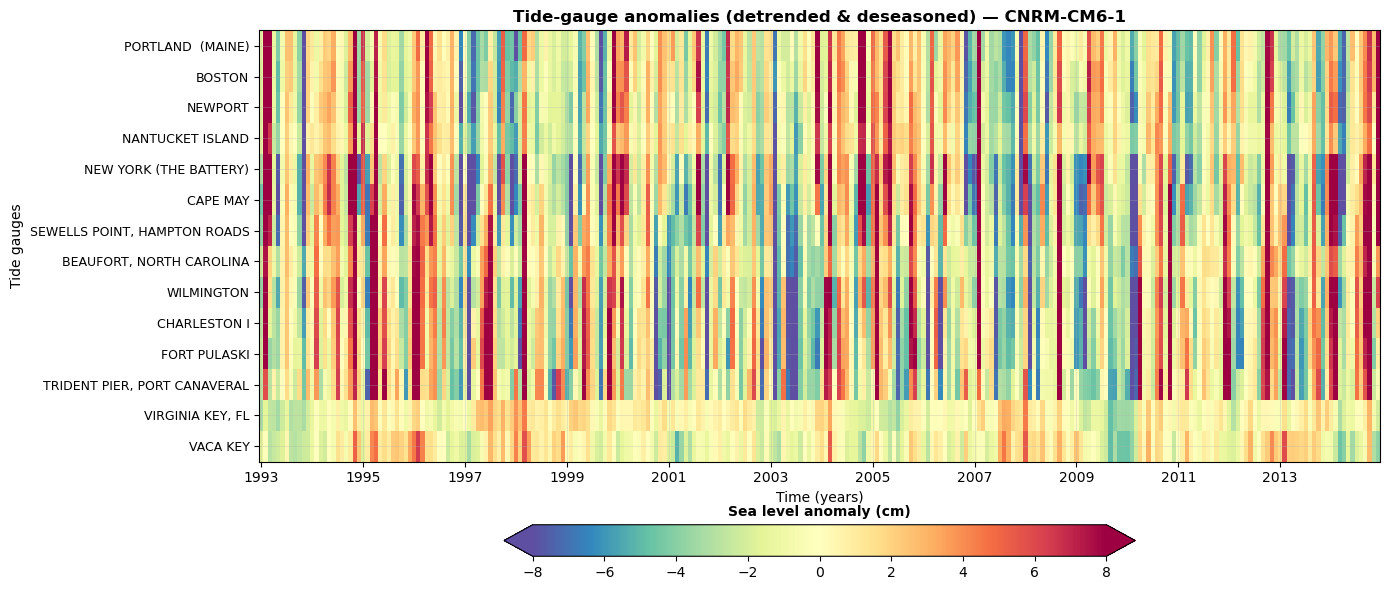

CNRM-CM6-1-HR


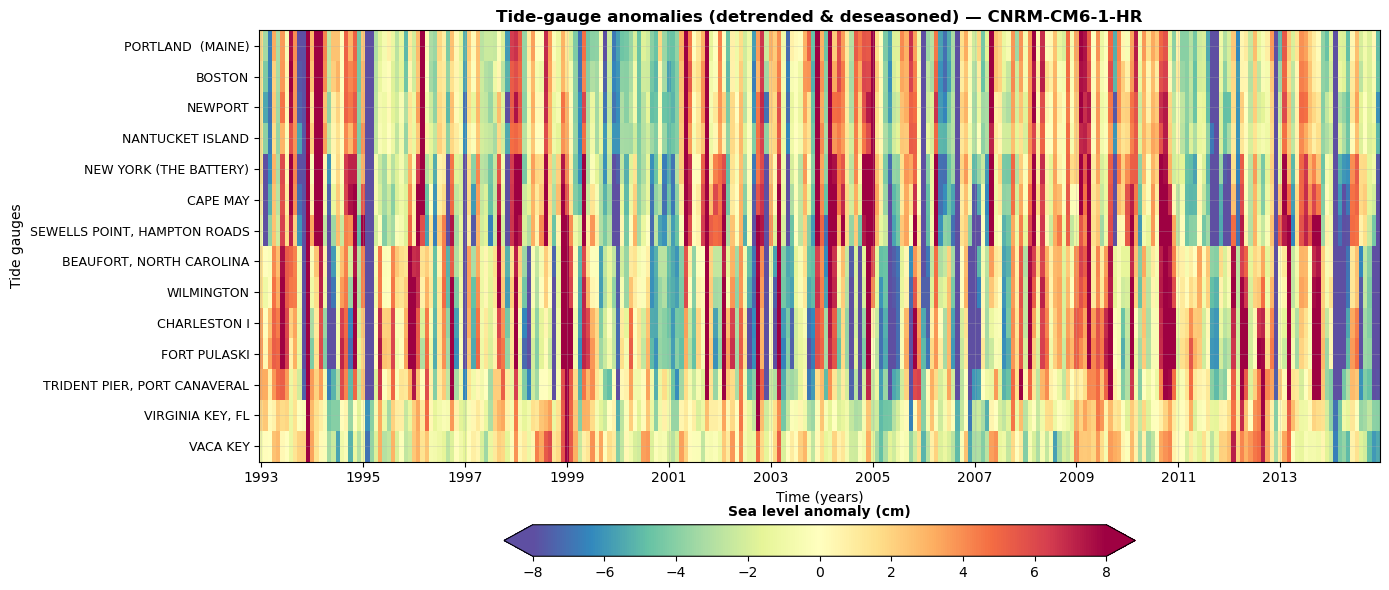

EC-Earth3P


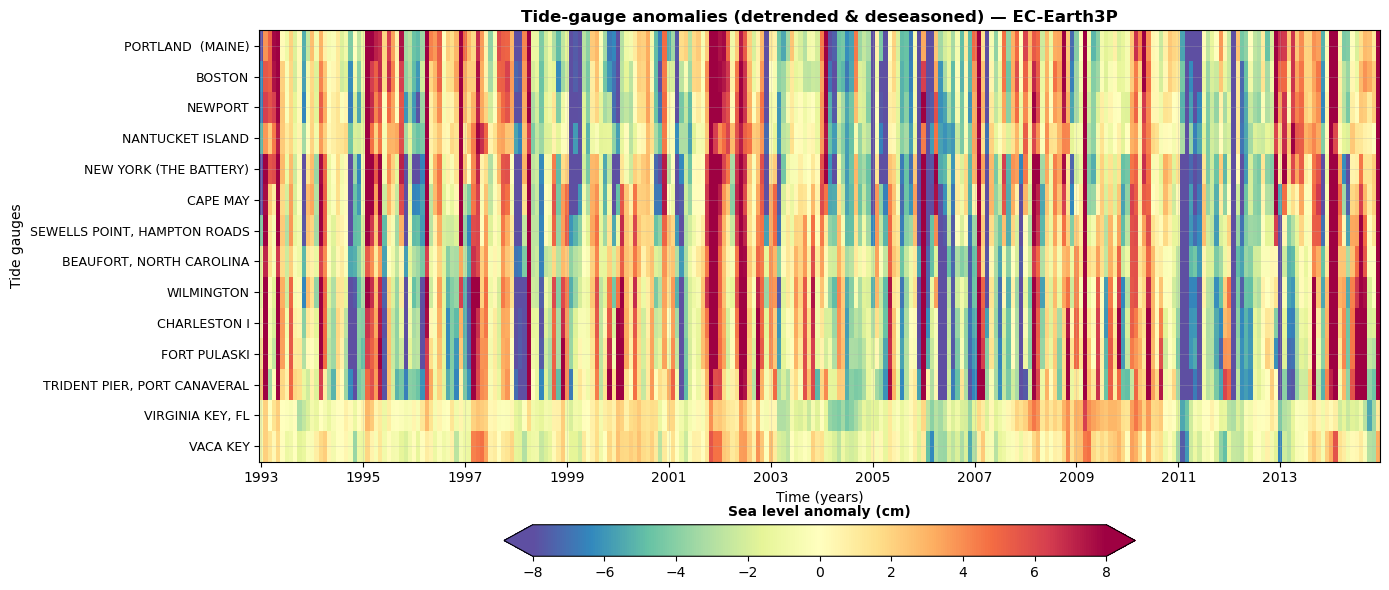

EC-Earth3P-HR


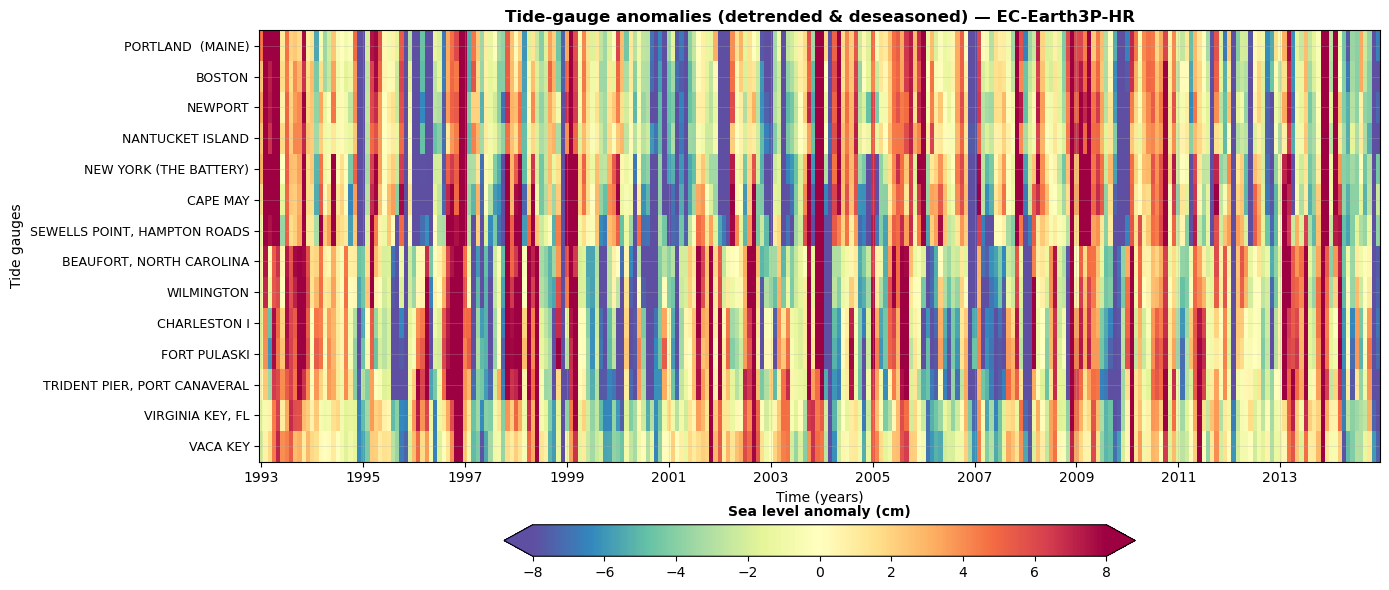

GFDL-ESM4


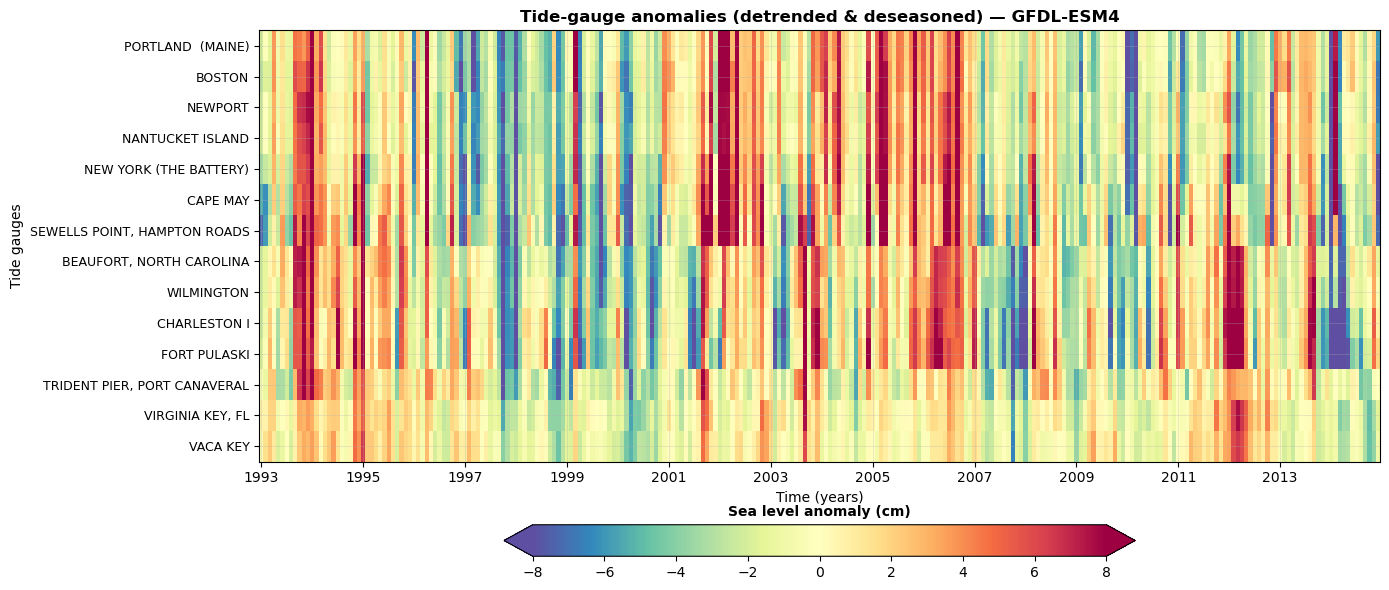

GFDL-CM4


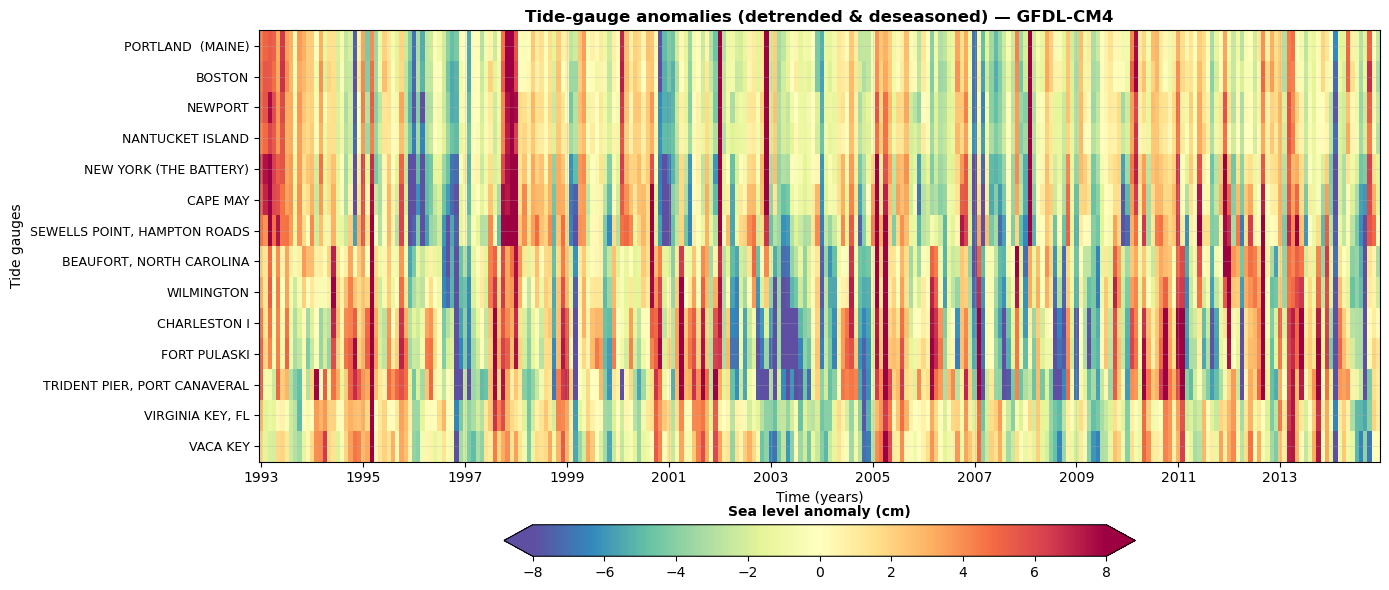

HadGEM3-GC31-LL


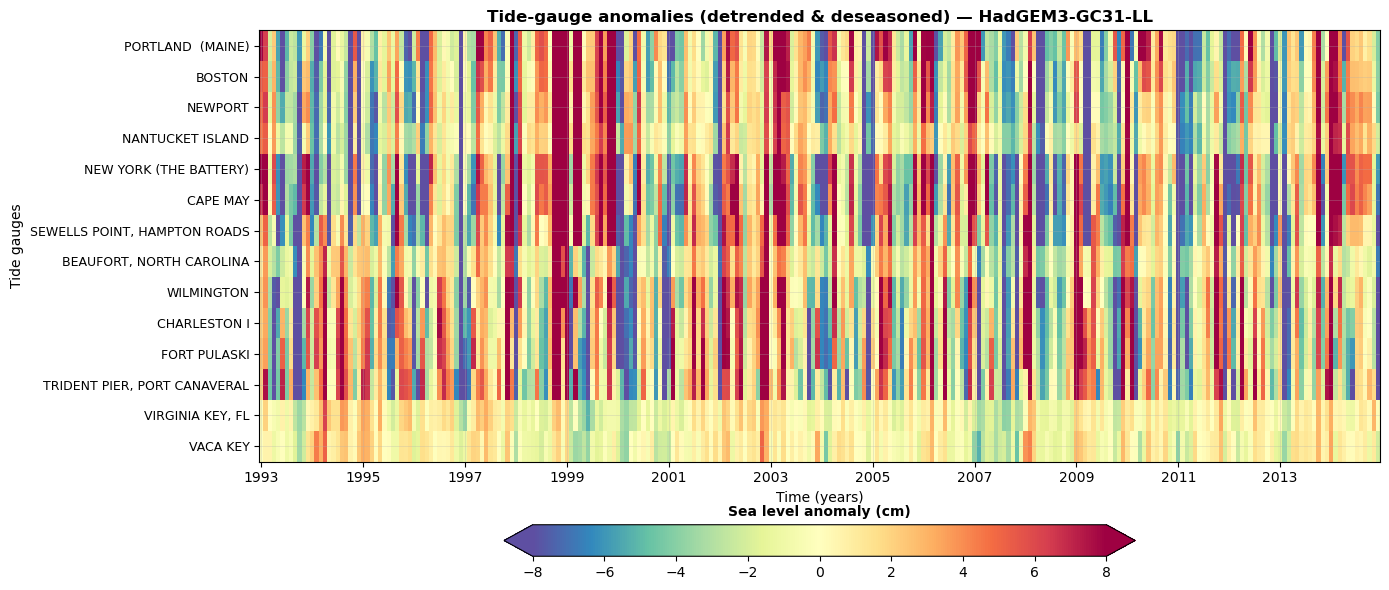

HadGEM3-GC31-MM


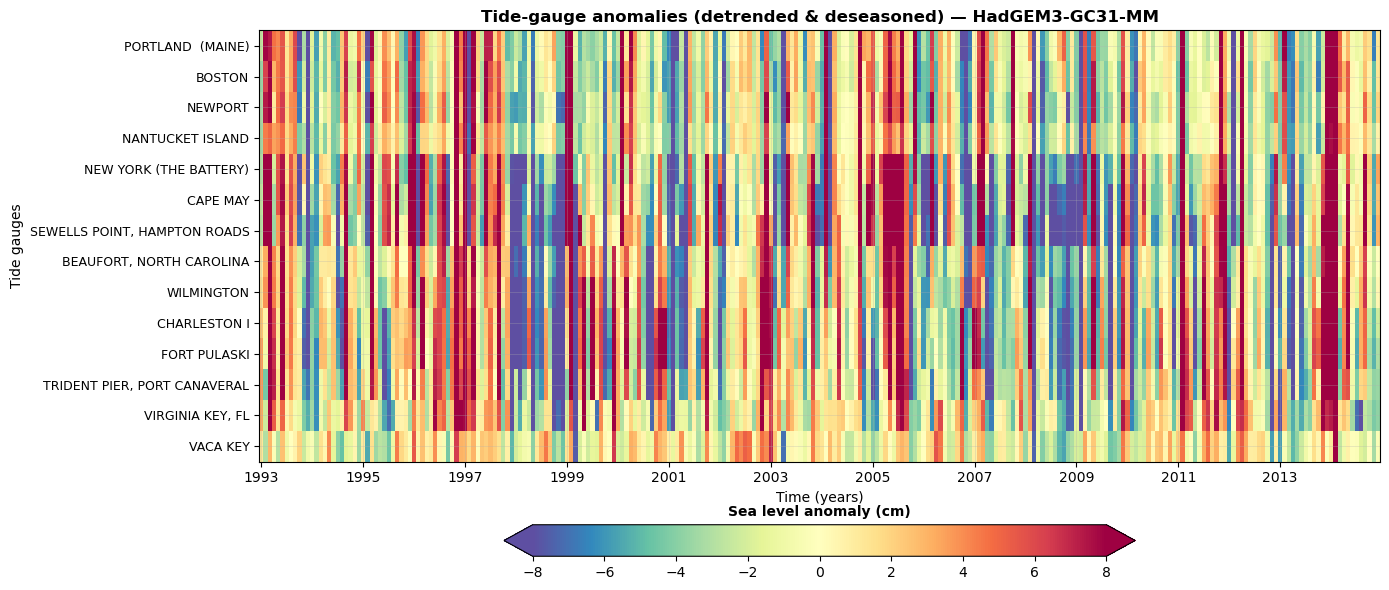

HadGEM3-GC31-HM


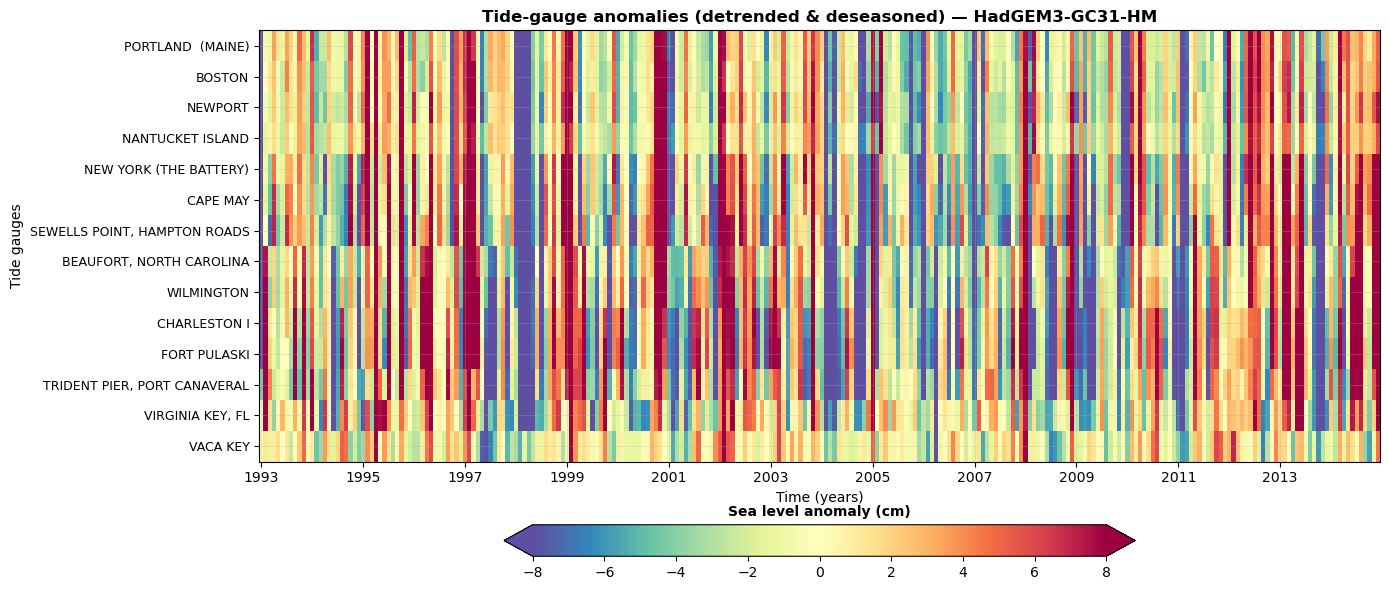

ECMWF-IFS-LR


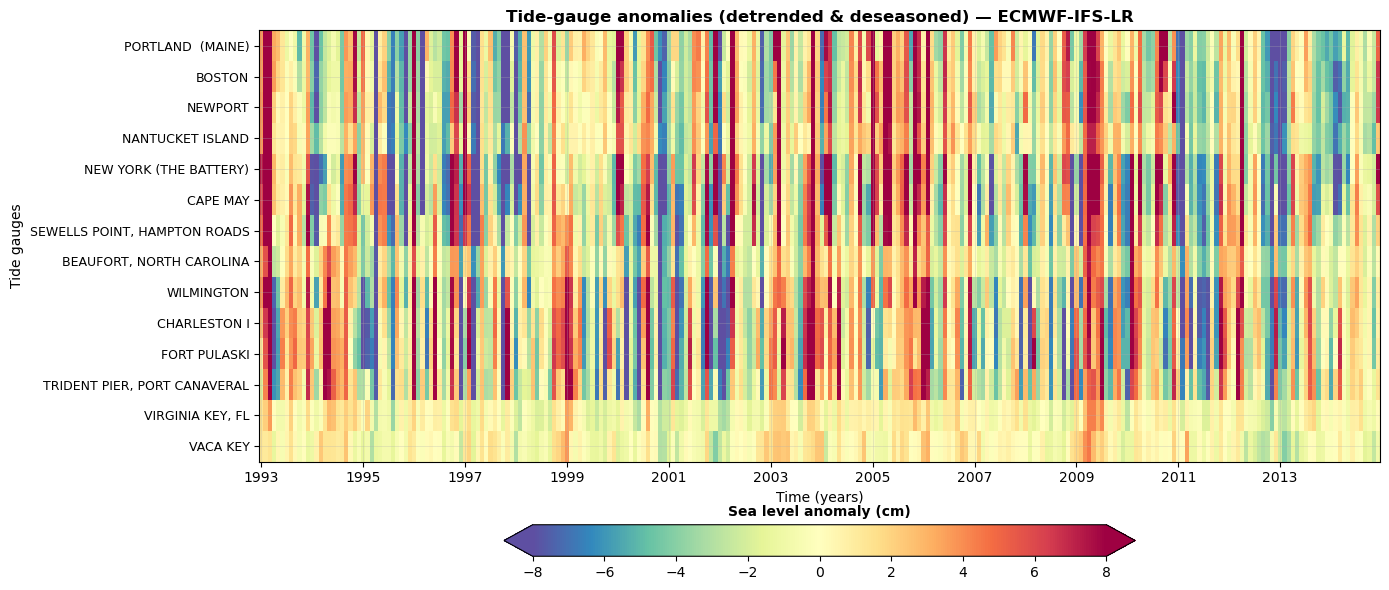

ECMWF-IFS-MR


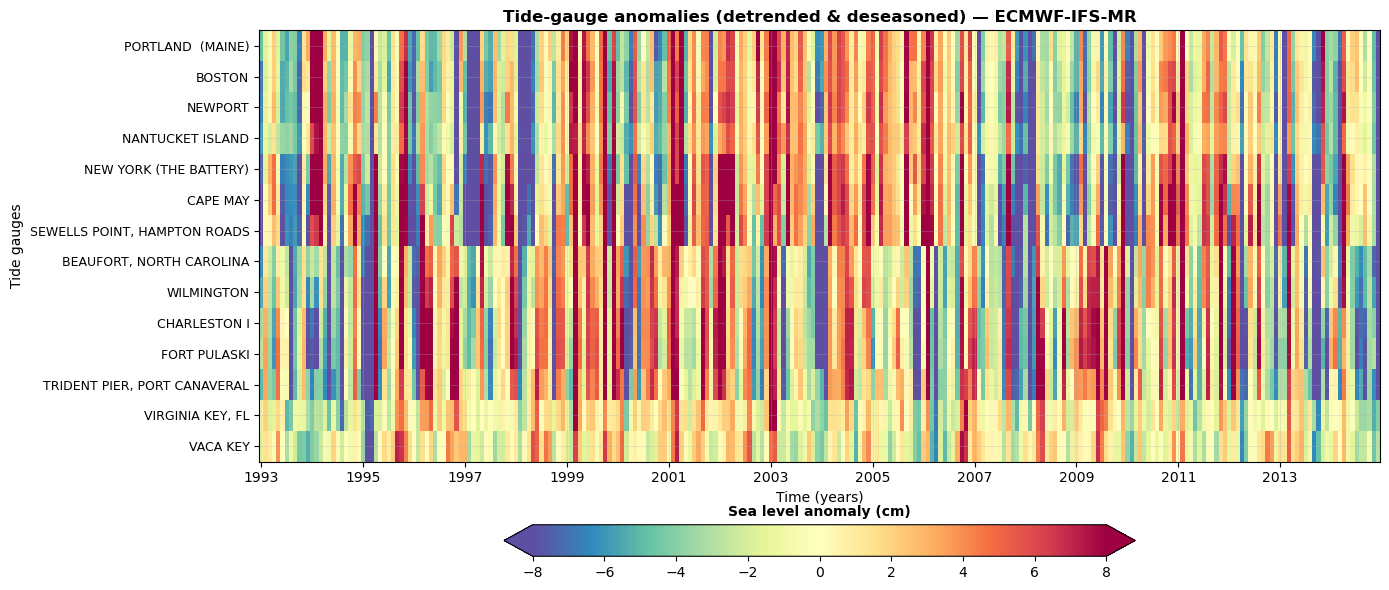

ECMWF-IFS-HR


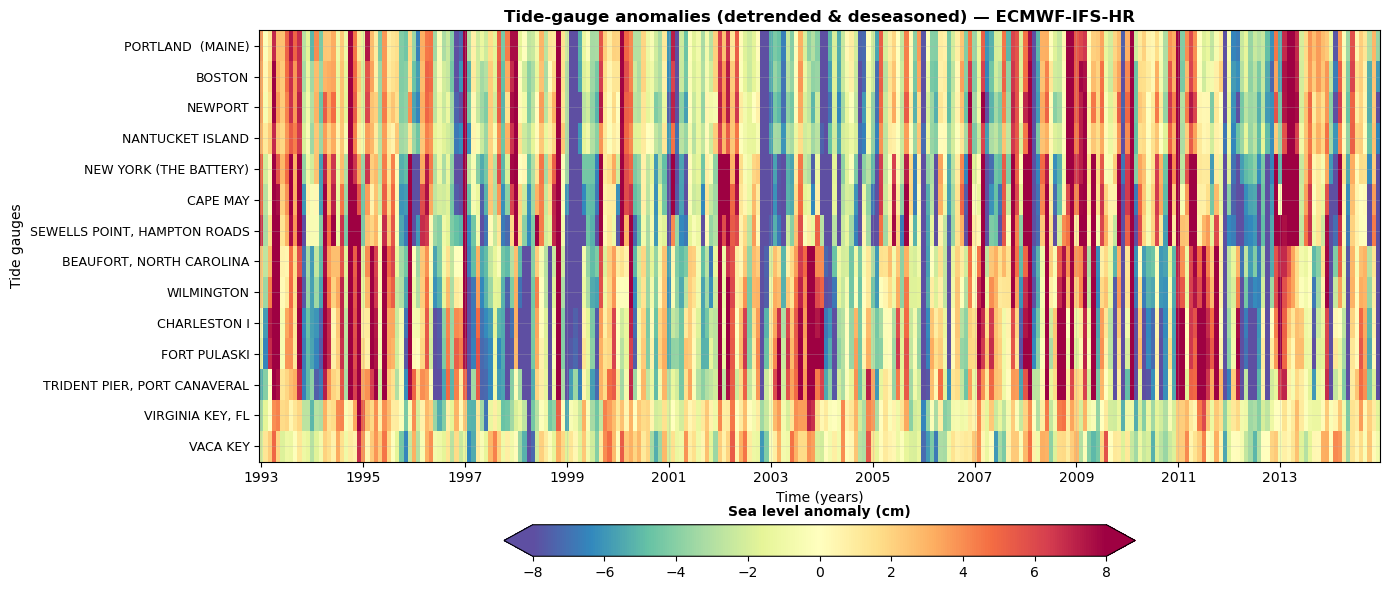

In [212]:
for i in range(len(source_ids)):
    tg_anom = tgs_anom[i]
    print(source_ids[i])
    plot_tg_hovmoller(tg_anom, tgnames, vlim_cm=8, cmap='Spectral_r', ylabspacing=1, out='s3.png',
                  title = f"Tide-gauge anomalies (detrended & deseasoned) — {source_ids[i]}")


In [47]:
import xeofs

kwargs = dict(n_modes=len(tgnames)-1,random_state=2)

#variables needed for plotting
da = tgs_anom[0]
model = xeofs.single.EOF(**kwargs)
model.fit(da.T, dim=("time"))

pcs_cm = model.scores()/100
norm_fac = np.real(pcs_cm).std(dim='time')
eofs_cm = model.components()/100
# 1) Core outputs from xeofs
expvar = model.explained_variance_ratio()      # (mode,)
#eofs   = model.components()                    # (mode, tgindex)  <-- map colors use this
pcs    = model.scores(normalized=True)         # (time, mode)     <-- PC panel uses this
eofs   = eofs_cm /norm_fac

# 2) Optional: total reconstruction and single-mode reconstructions
rect = model.inverse_transform(pcs, normalized=True)   # (time, tgindex)

# single-mode reconstructions: keep only mode k across all time
rec_modes = []
for k in range(min(3, eofs.sizes['mode'])):
    # robust: select kth mode by position then zero-fill others
    pcs_k = pcs.isel(mode=[k]).reindex(mode=pcs.mode, fill_value=0)
    rec_k = model.inverse_transform(pcs_k, normalized=True)
    rec_modes.append(rec_k)

# 3) Units for plotting
# If your anomalies are meters, convert EOF loadings to cm for the map colorbar
eofs_cm = eofs * 100.0   # drop this line if you already work in cm

# 4) Per-station variance fraction (if you want dot size ~ variance explained)
tot_var = rect.var(dim='time')                            # (tgindex)
ve_mode0 = (rec_modes[0].var(dim='time') / tot_var)       # (tgindex)
# ve_mode1, ve_mode2 similarly if needed


In [48]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_tg_eofs_colors_only(eofs, pcs, expvar, lon, lat,
                             *, unit='m', cmap='Spectral_r',
                             vmax_cm=7, dot_size=300,
                             extent=(-78, -74, 20, 48),
                             title=None):
    # Convert EOF loadings to cm if input is in meters
    #scale = 100.0 if unit == 'm' else 1.0
    #eofs_cm = eofs * scale

    proj = ccrs.RotatedPole(pole_longitude=25.0, pole_latitude=70.0)
    fig = plt.figure(figsize=(13, 9))
    gs = fig.add_gridspec(nrows=3, ncols=3, height_ratios=[1, 1, 0.7],
                          hspace=0.25, wspace=0.25)

    nmaps = int(min(3, eofs_cm.sizes['mode']))
    axes = []
    for k in range(nmaps):
        ax = fig.add_subplot(gs[:2, k], projection=proj)  # top two rows
        sc = ax.scatter(lon, lat,
                        c=eofs.isel(mode=k).values,
                        s=dot_size, vmin=-vmax_cm, vmax=vmax_cm,
                        cmap=cmap, edgecolors='k', linewidth=0.8, alpha=1.0,
                        transform=ccrs.PlateCarree(), zorder=7)
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.LAND.with_scale('110m'), zorder=2, facecolor='.92')
        ax.add_feature(cfeature.COASTLINE, zorder=5)
        ax.add_feature(cfeature.STATES, edgecolor='k', zorder=4)
        ax.add_feature(cfeature.LAKES, edgecolor='k', facecolor='none', zorder=4)
        ax.gridlines(draw_labels=False, linewidth=0.5, alpha=0.4)

        # % variance label
        pct = float(expvar.isel(mode=k).values) * 100.0
        ax.text(0.03, 0.04, f'{pct:.0f}%', transform=ax.transAxes, fontsize=11, weight='bold')

        axes.append(ax)

    # inset colorbar anchored to the first map
    cax = inset_axes(axes[0], width="6%", height="50%", loc='center right',
                     bbox_to_anchor=(0.0, 0.0, 0.9, 1), bbox_transform=axes[0].transAxes, borderpad=0)
    cb = fig.colorbar(sc, cax=cax, orientation='vertical', extend='both', ticklocation='left')
    cb.ax.set_title('EOF (cm/SD)', fontsize=9, weight='bold')

    # PC panel on bottom row
    ax_pc = fig.add_subplot(gs[2, :])
    nplot = min(3, pcs.sizes['mode'])
    for k in range(2):
        pcs.isel(mode=k).plot(ax=ax_pc, label=f'PC{k+1}', linewidth=1.5)
    ax_pc.grid(True, alpha=0.5)
    ax_pc.set_ylabel('Normalized PC')
    ax_pc.legend(loc='upper right')

    if title:
        fig.suptitle(title, y=0.98, weight='bold')

    # leave a tiny margin for the suptitle, but no big top gap
    #plt.tight_layout(rect=[0, 0, 1, 1])
    plt.tight_layout()
    plt.show()


/glade/derecho/scratch/netige/tmp/ipykernel_39810/3089346295.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


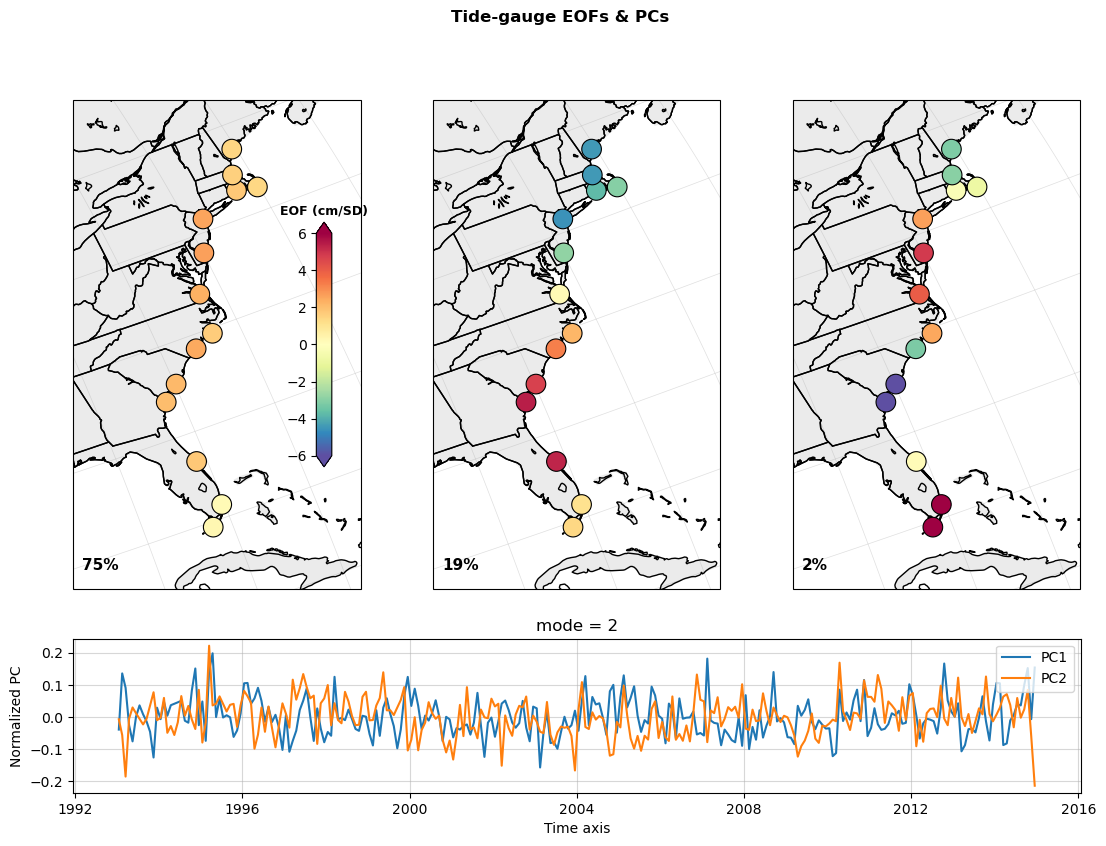

In [49]:
# After fitting your model:
#eofs  = model.components()                   # (mode, tgindex)
#pcs   = model.scores(normalized=True)        # (time, mode)
#expvr = model.explained_variance_ratio()     # (mode,)

plot_tg_eofs_colors_only(
    eofs, pcs, expvr,
    lon=tgs_in.lon.values, lat=tgs_in.lat.values,
    unit='m', cmap='Spectral_r', vmax_cm=6, dot_size=200,
    extent=(-78, -74, 20, 48),
    title='Tide-gauge EOFs & PCs'
)


In [50]:
%%time
#for loop to run through all models

expvar_models = []
eofs_models = []
pcs_models = []

for i in range(len(source_ids)):
    da = tgs_anom[i]
    model = xeofs.single.EOF(**kwargs)
    model.fit(da.T, dim=("time"))

    pcs_cm = model.scores()/100
    norm_fac = np.real(pcs_cm).std(dim='time')
    
    eofs_cm = model.components()/100
    # 1) Core outputs from xeofs
    expvar = model.explained_variance_ratio()      # (mode,)
    #eofs   = model.components()                    # (mode, tgindex)  <-- map colors use this
    pcs    = pcs_cm/norm_fac        # (time, mode)     <-- PC panel uses this
    eofs   = eofs_cm /norm_fac

    # 1) Core outputs from xeofs
    #expvar = model.explained_variance_ratio()      # (mode,)
    #eofs   = model.components()                    # (mode, tgindex)  <-- map colors use this
    #pcs    = model.scores(normalized=True)         # (time, mode)     <-- PC panel uses this

    expvar_models.append(expvar)
    eofs_models.append(eofs)
    pcs_models.append(pcs)
    
    print('Done with ' + source_ids[i])
    # 2) Optional: total reconstruction and single-mode reconstructions
    #rect = model.inverse_transform(pcs, normalized=True)   # (time, tgindex)

    # single-mode reconstructions: keep only mode k across all time
    #rec_modes = []
    #for k in range(min(3, eofs.sizes['mode'])):
        # robust: select kth mode by position then zero-fill others
        #pcs_k = pcs.isel(mode=[k]).reindex(mode=pcs.mode, fill_value=0)
        #rec_k = model.inverse_transform(pcs_k, normalized=True)
        #rec_modes.append(rec_k)

    # 3) Units for plotting
    # convert EOF loadings to cm for the map colorbar
    #eofs_cm = eofs * 100.0   # drop this line if you already work in cm

    # 4) Per-station variance fraction (if you want dot size ~ variance explained)
    #tot_var = rect.var(dim='time')                            # (tgindex)
    #ve_mode0 = (rec_modes[0].var(dim='time') / tot_var)       # (tgindex)
    # ve_mode1, ve_mode2 similarly if needed

    
    


Done with CNRM-CM6-1
Done with CNRM-CM6-1-HR
Done with EC-Earth3P
Done with EC-Earth3P-HR
Done with GFDL-ESM4
Done with GFDL-CM4
Done with HadGEM3-GC31-LL
Done with HadGEM3-GC31-MM
Done with HadGEM3-GC31-HM
Done with ECMWF-IFS-LR
Done with ECMWF-IFS-MR
Done with ECMWF-IFS-HR
CPU times: user 1min 50s, sys: 2.85 s, total: 1min 53s
Wall time: 3min 46s


CNRM-CM6-1


/glade/derecho/scratch/netige/tmp/ipykernel_39810/3089346295.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


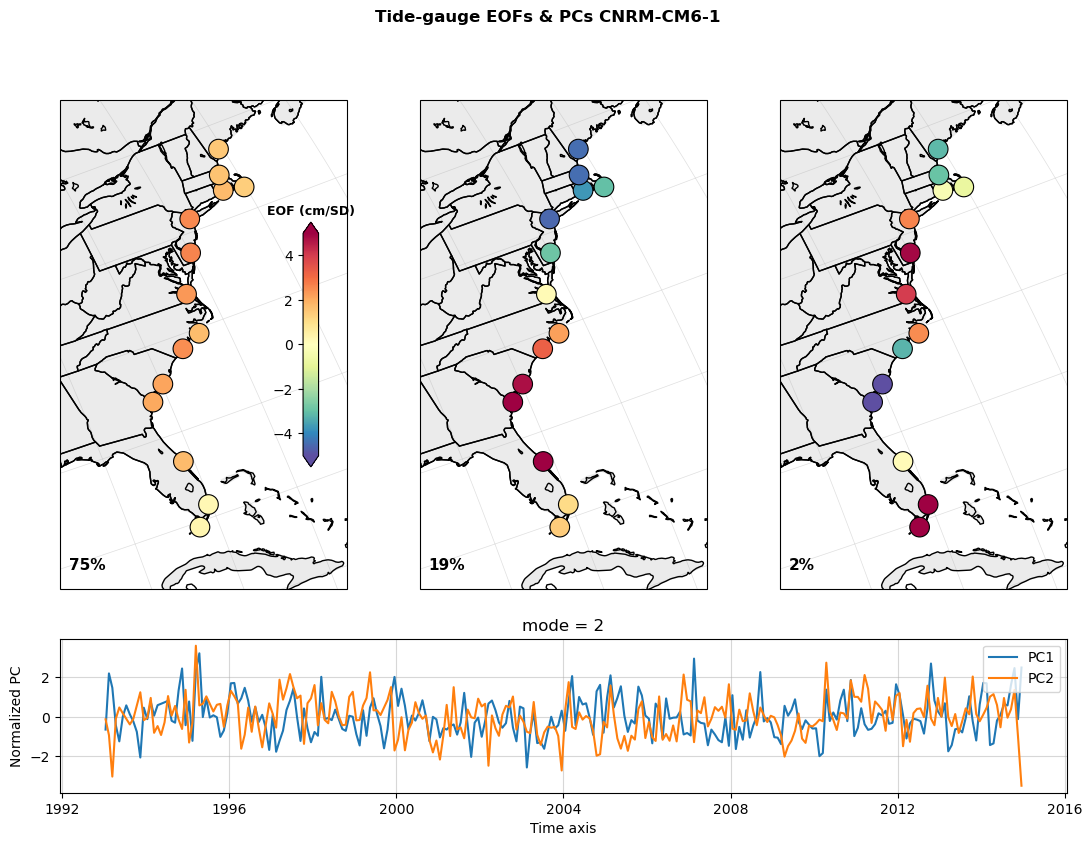

CNRM-CM6-1-HR


/glade/derecho/scratch/netige/tmp/ipykernel_39810/3089346295.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


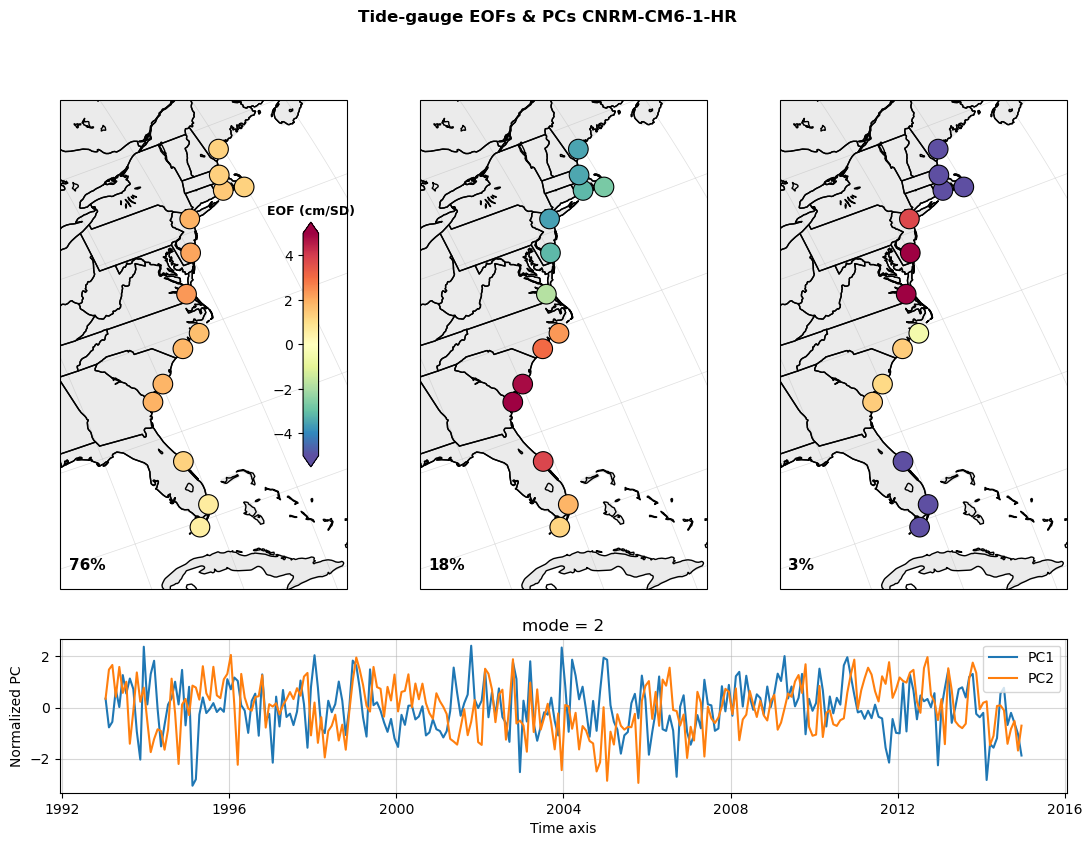

EC-Earth3P


/glade/derecho/scratch/netige/tmp/ipykernel_39810/3089346295.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


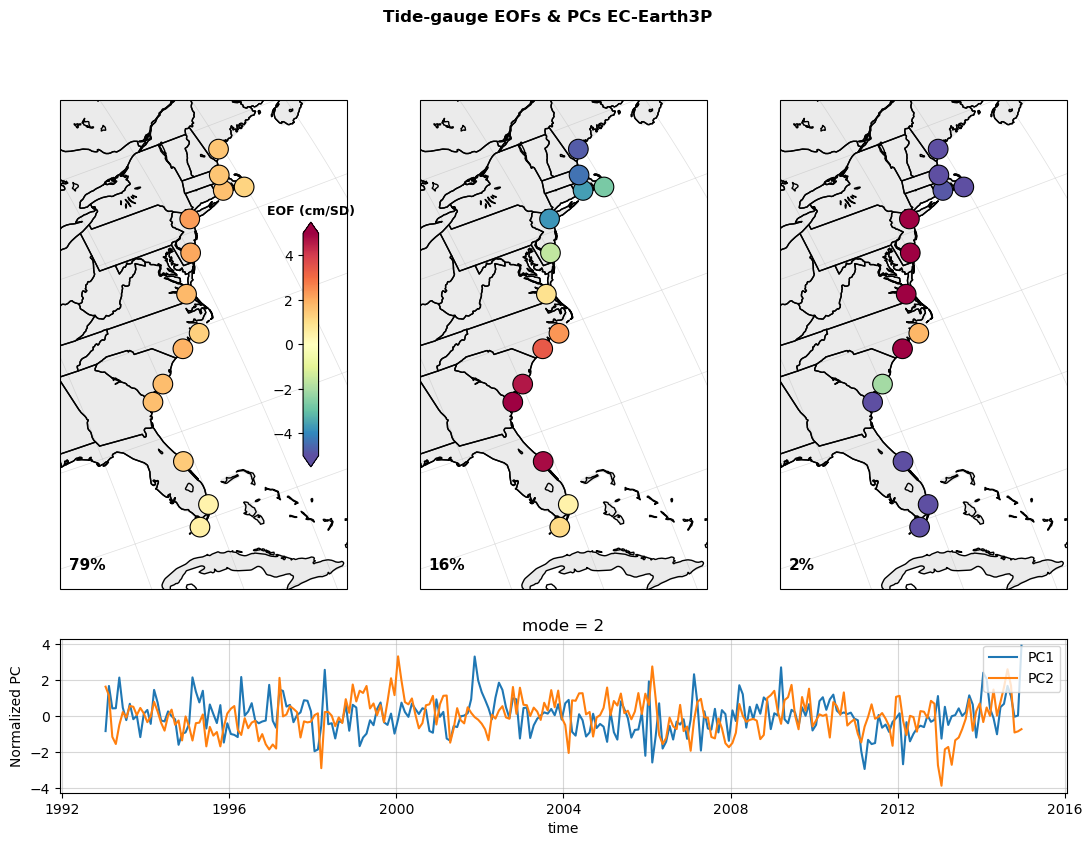

EC-Earth3P-HR


/glade/derecho/scratch/netige/tmp/ipykernel_39810/3089346295.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


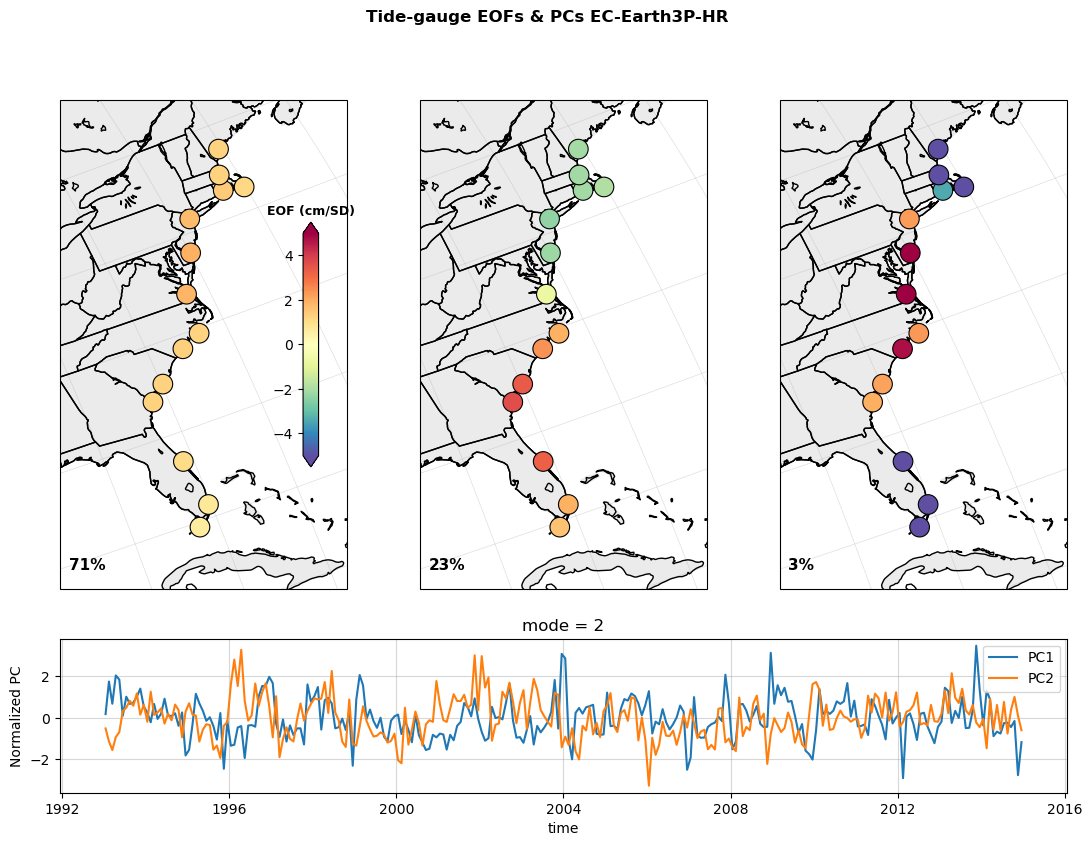

GFDL-ESM4


/glade/derecho/scratch/netige/tmp/ipykernel_39810/3089346295.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


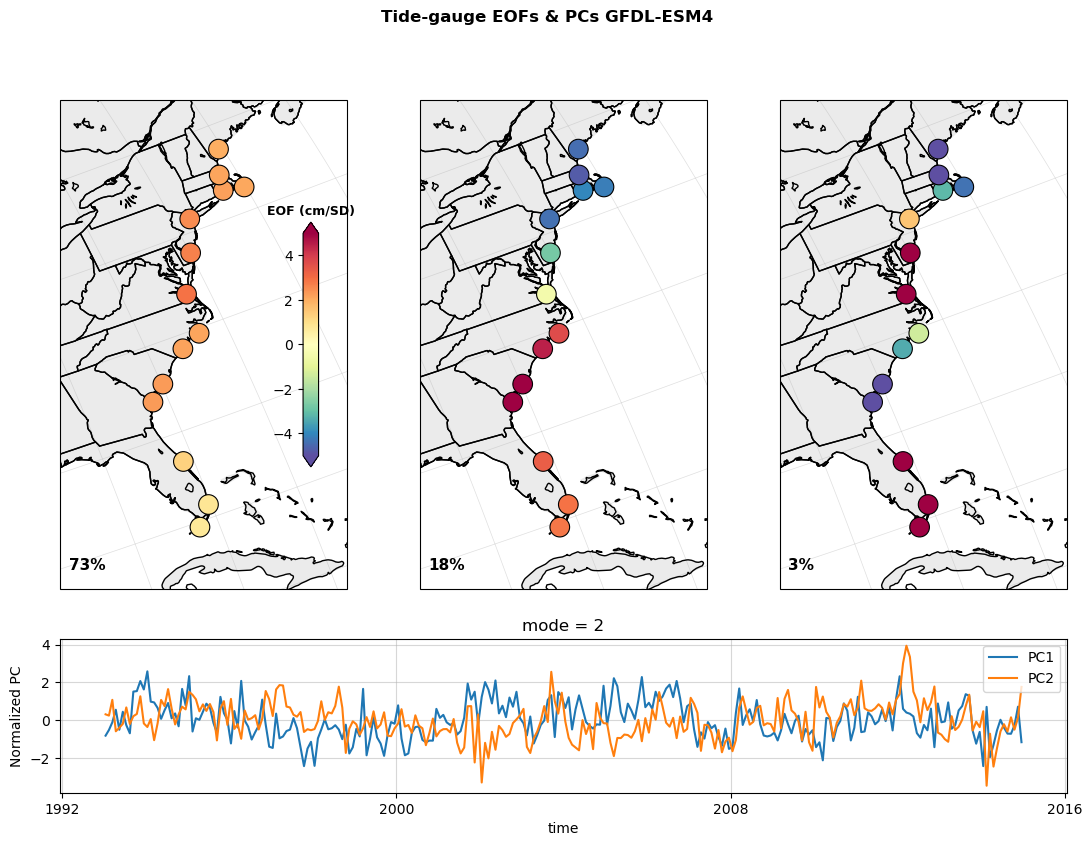

GFDL-CM4


/glade/derecho/scratch/netige/tmp/ipykernel_39810/3089346295.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


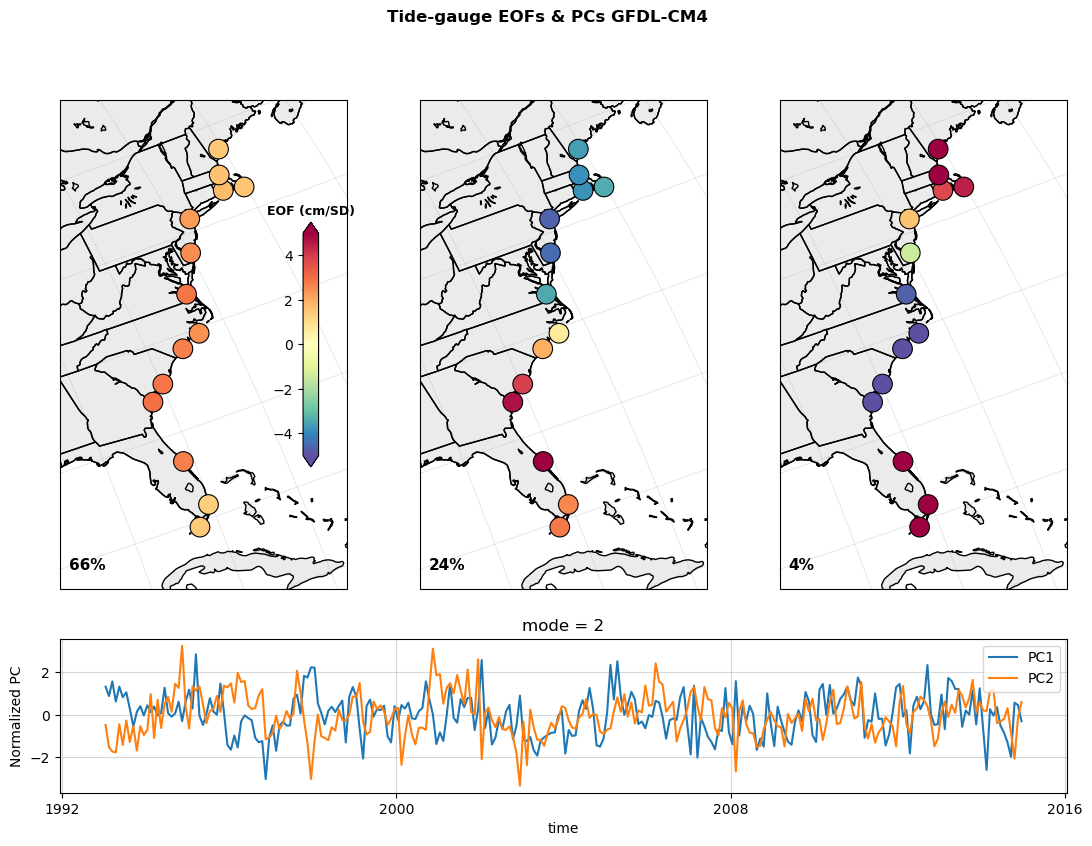

HadGEM3-GC31-LL


/glade/derecho/scratch/netige/tmp/ipykernel_39810/3089346295.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


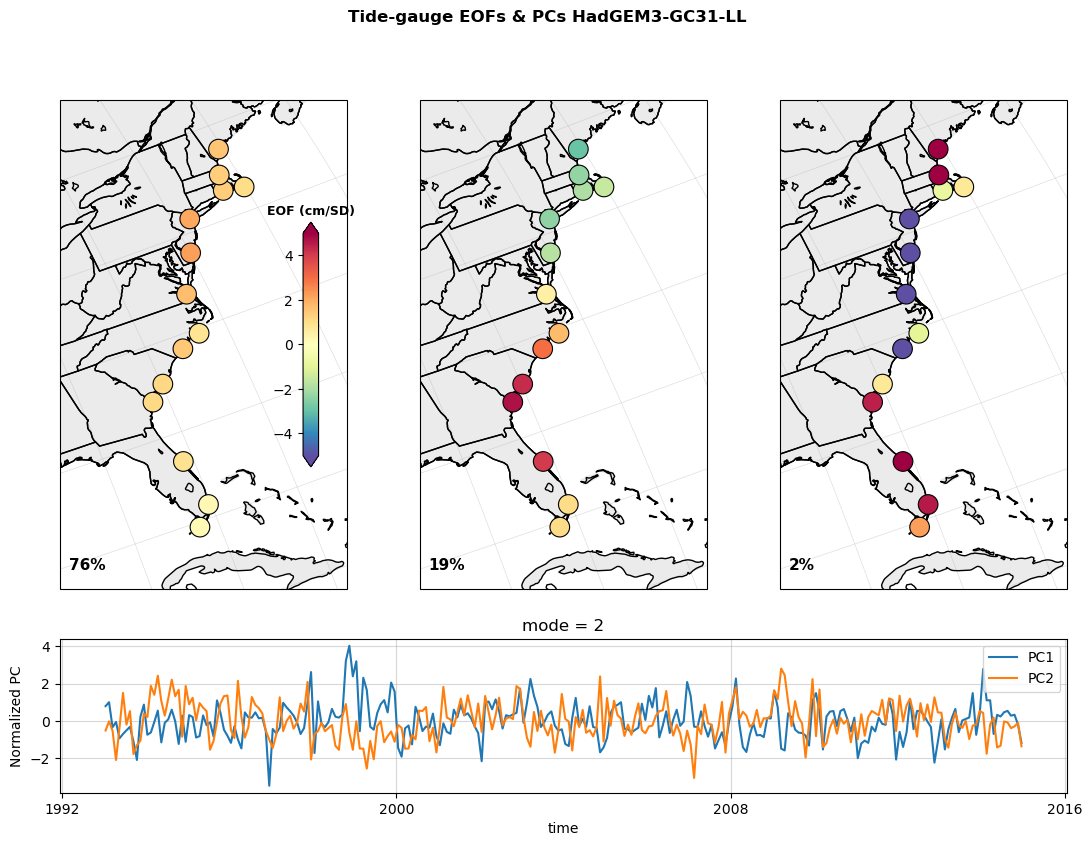

HadGEM3-GC31-MM


/glade/derecho/scratch/netige/tmp/ipykernel_39810/3089346295.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


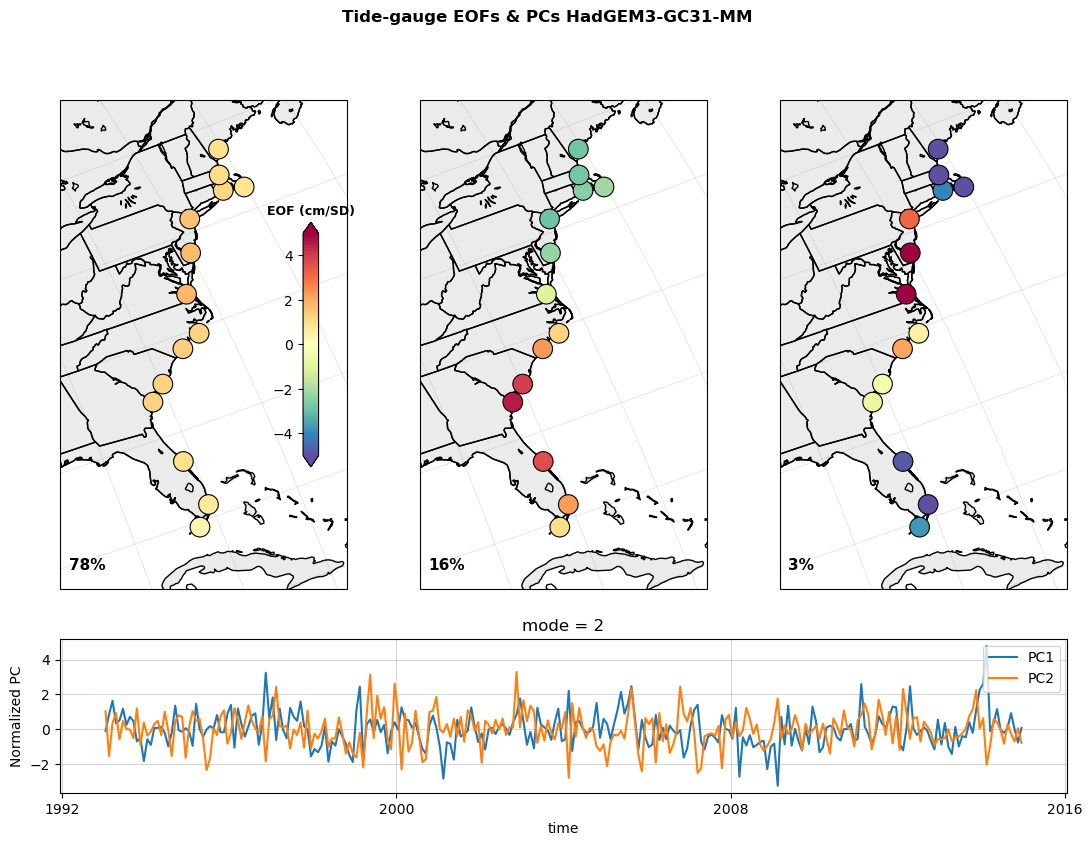

HadGEM3-GC31-HM


/glade/derecho/scratch/netige/tmp/ipykernel_39810/3089346295.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


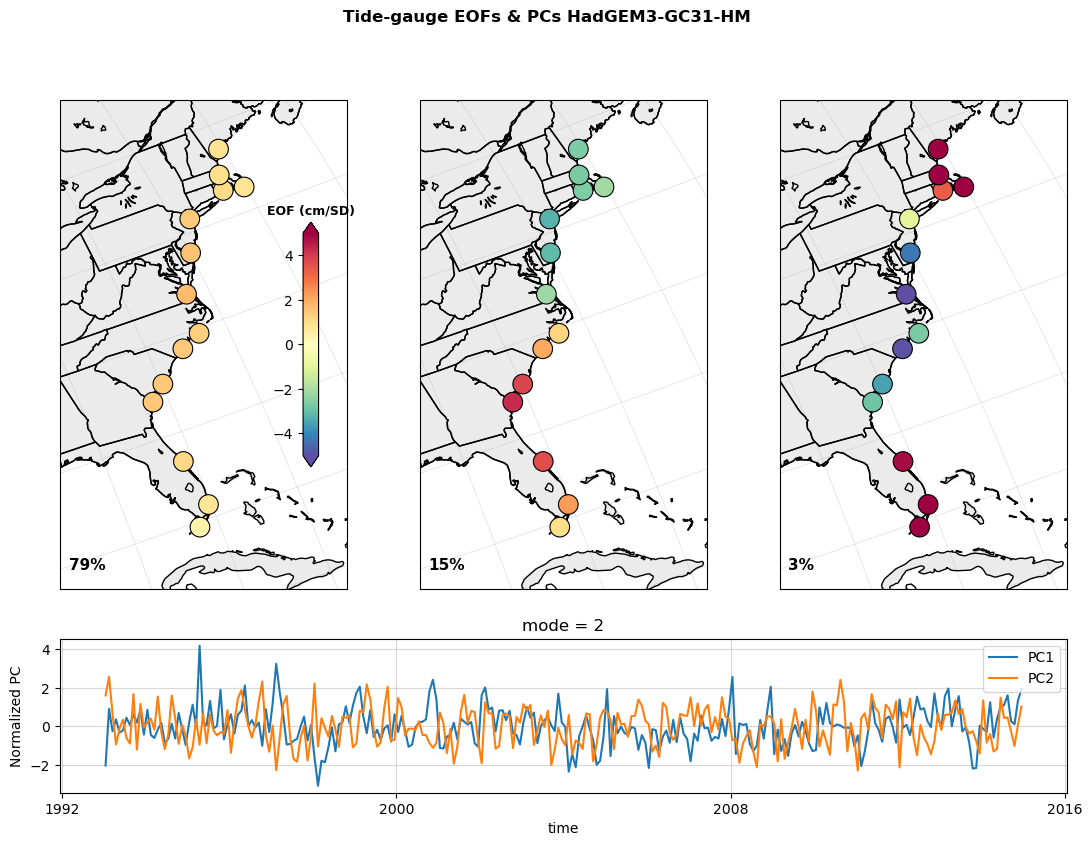

ECMWF-IFS-LR


/glade/derecho/scratch/netige/tmp/ipykernel_39810/3089346295.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


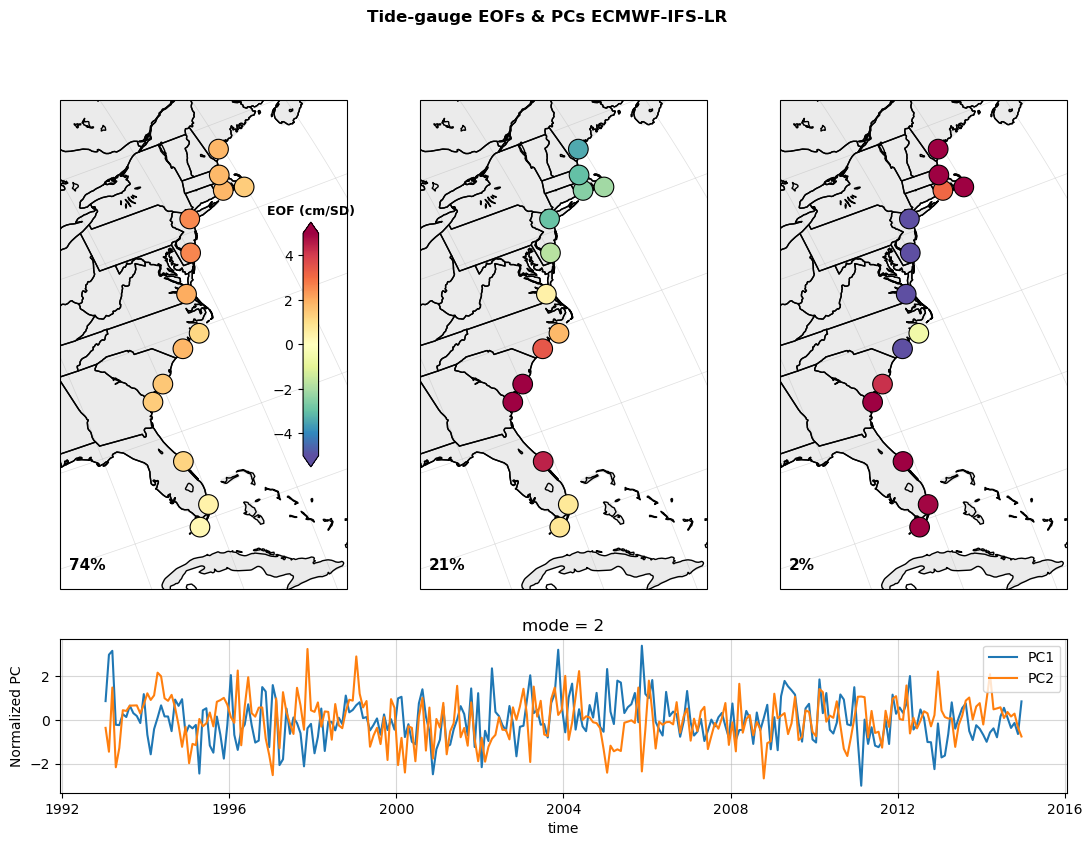

ECMWF-IFS-MR


/glade/derecho/scratch/netige/tmp/ipykernel_39810/3089346295.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


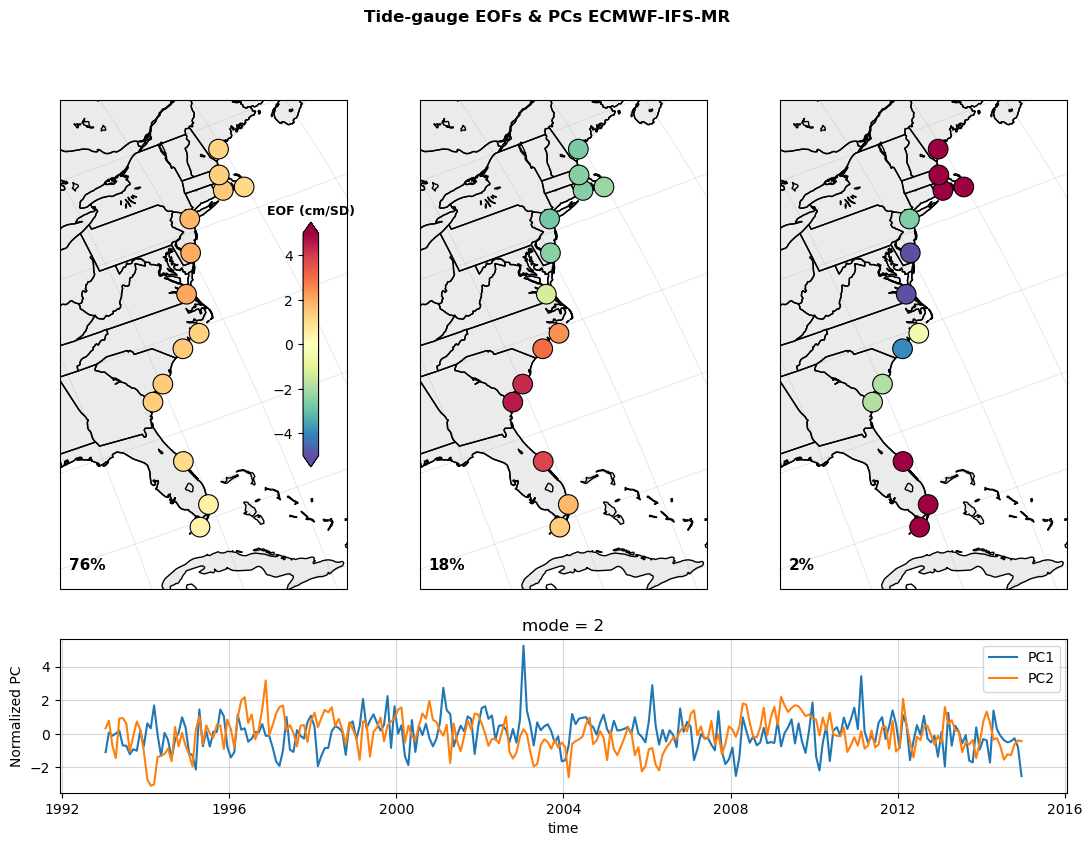

ECMWF-IFS-HR


/glade/derecho/scratch/netige/tmp/ipykernel_39810/3089346295.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


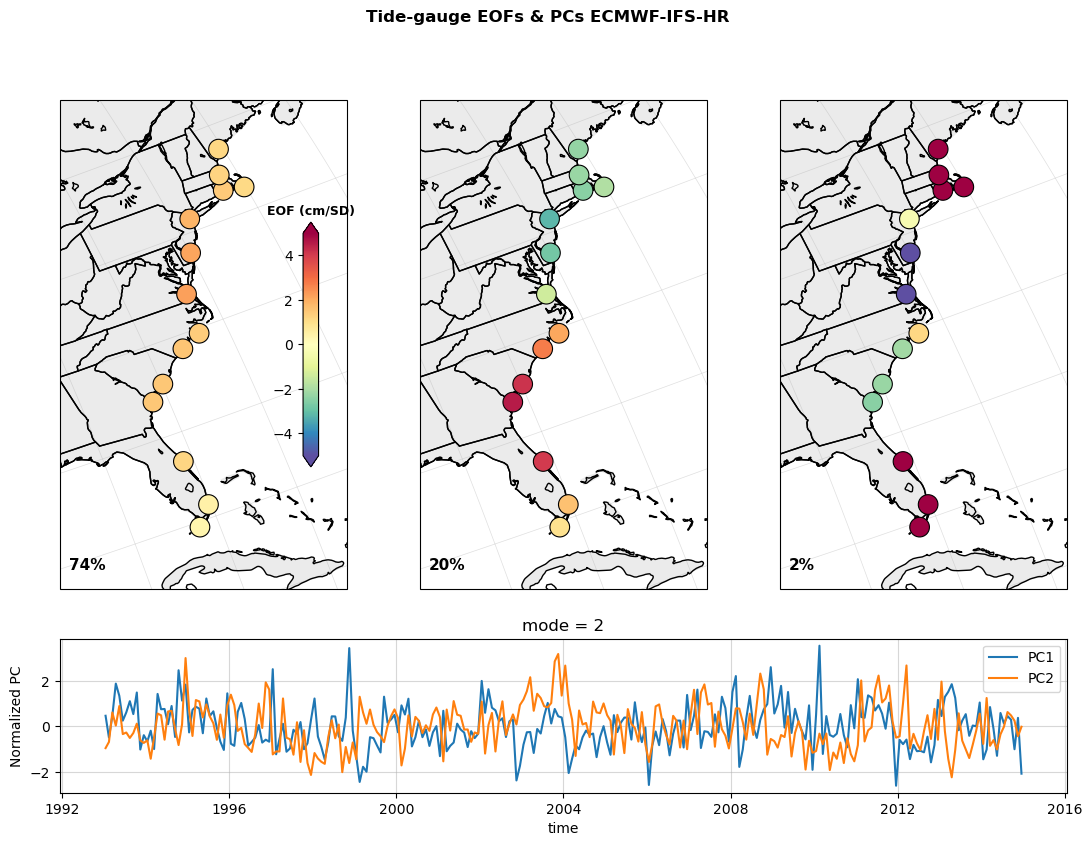

CPU times: user 4.16 s, sys: 12.3 ms, total: 4.17 s
Wall time: 4.52 s


In [54]:
%%time
for i in range(len(source_ids)):
    print(source_ids[i])
    eof = eofs_models[i]
    pc = pcs_models[i]
    expvar = expvar_models[i]
    plot_tg_eofs_colors_only(
        eof, pc, expvar,
        lon=tgs_in.lon.values, lat=tgs_in.lat.values,
        unit='m', cmap='Spectral_r', vmax_cm=5, dot_size=200,
        extent=(-78, -74, 20, 48),
        #title='Tide-gauge EOFs & PCs'
        title = f"Tide-gauge EOFs & PCs {source_ids[i]}")



#### Roughwork

In [156]:
model.fit(da.T, dim=("time"))


In [144]:
model.explained_variance()

<xarray.DataArray 'explained_variance' (mode: 13)> Size: 104B
array([1.85634661e-02, 4.10295679e-03, 7.40228330e-04, 6.24309529e-04,
       2.21639910e-04, 1.79260788e-04, 1.21481204e-04, 5.43586177e-05,
       3.70605111e-05, 2.80566361e-05, 1.79270560e-05, 1.40559182e-05,
       1.24049821e-05])
Coordinates:
  * mode     (mode) int64 104B 1 2 3 4 5 6 7 8 9 10 11 12 13
Attributes: (12/15)
    model:          EOF analysis
    software:       xeofs
    version:        3.0.4
    date:           2025-09-03 09:31:22
    n_modes:        13
    center:         True
    ...             ...
    sample_name:    sample
    feature_name:   feature
    random_state:   2
    compute:        True
    solver:         auto
    solver_kwargs:  {}

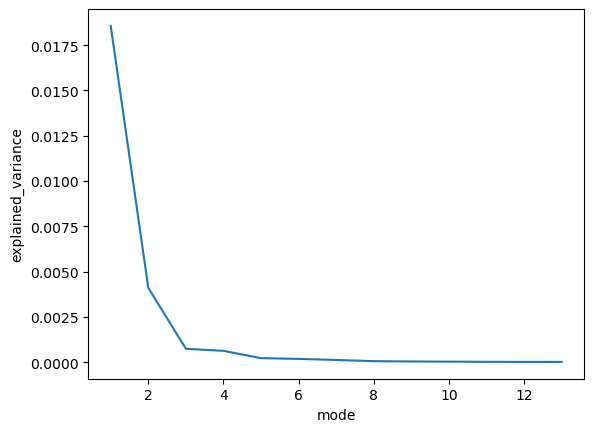

In [114]:
model.explained_variance().plot()

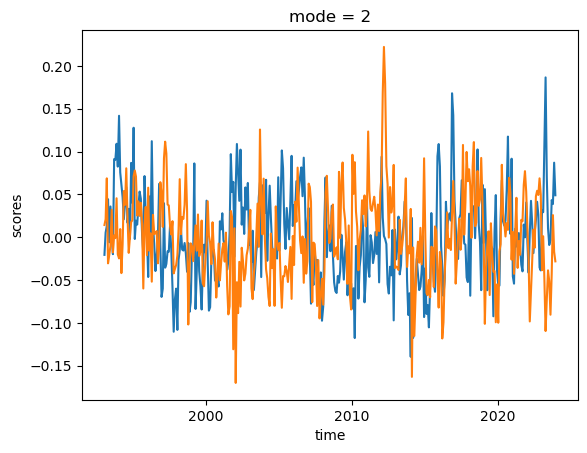

In [115]:
model.scores(normalized=True).isel(mode=0).plot()
model.scores(normalized=True).isel(mode=1).plot()

In [118]:
model.components().isel(mode=0)

<xarray.DataArray 'components' (tgindex: 14)> Size: 112B
array([0.10408143, 0.10903123, 0.18207139, 0.29498864, 0.29520244,
       0.27297436, 0.26932911, 0.35737542, 0.33435311, 0.31997709,
       0.26284479, 0.27956017, 0.26739379, 0.24955573])
Coordinates:
    mode     int64 8B 1
  * tgindex  (tgindex) <U4 224B '1701' '1858' '2123' '395' ... '351' '235' '183'
Attributes: (12/15)
    model:          EOF analysis
    software:       xeofs
    version:        3.0.4
    date:           2025-09-03 09:31:22
    n_modes:        13
    center:         True
    ...             ...
    sample_name:    sample
    feature_name:   feature
    random_state:   2
    compute:        True
    solver:         auto
    solver_kwargs:  {}

In [86]:


# X must be (time, tgindex)
X = da2.transpose('time', 'tgindex')

# Make SVD-friendly: single chunk along time (and tgindex)
X = X.chunk({'time': -1, 'tgindex': -1})  # one chunk for each dim

model = xeofs.single.EOF(n_modes=min(X.sizes['time'], X.sizes['tgindex'])-1, random_state=2)
model.fit(X, dim='time')  # use a STRING, not ("time",)


In [220]:
model.explained_variance_ratio()

<xarray.DataArray 'explained_variance_ratio' (mode: 13)> Size: 104B
array([7.47405050e-01, 1.94806203e-01, 1.87932993e-02, 1.58728062e-02,
       8.51235237e-03, 4.07587792e-03, 3.50378890e-03, 2.68891987e-03,
       1.79929600e-03, 1.17458957e-03, 6.79310428e-04, 2.95950690e-04,
       2.47159818e-04])
Coordinates:
  * mode     (mode) int64 104B 1 2 3 4 5 6 7 8 9 10 11 12 13
Attributes: (12/15)
    model:          EOF analysis
    software:       xeofs
    version:        3.0.4
    date:           2025-09-03 13:21:05
    n_modes:        13
    center:         True
    ...             ...
    sample_name:    sample
    feature_name:   feature
    random_state:   2
    compute:        True
    solver:         auto
    solver_kwargs:  {}

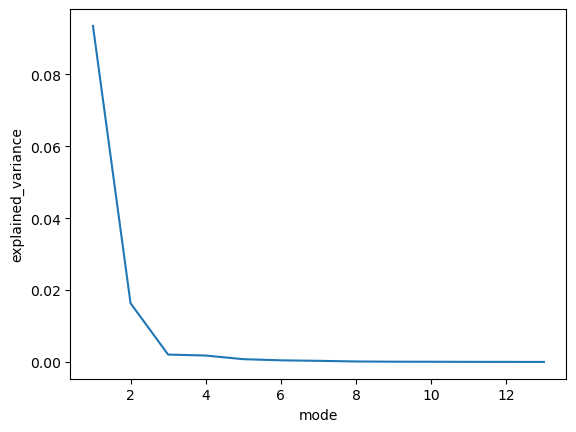

In [88]:
model.explained_variance().plot()

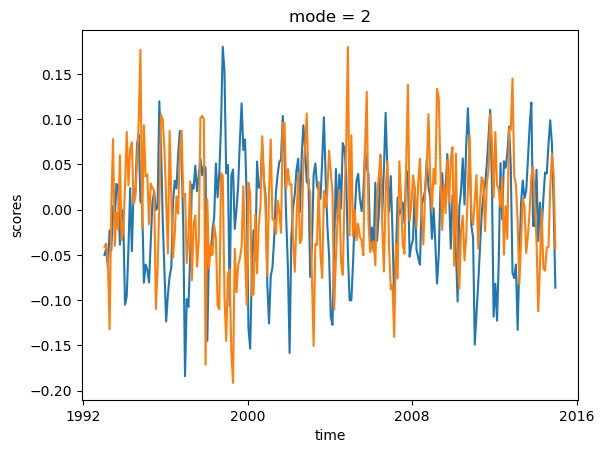

In [104]:
model.scores(normalized=True).isel(mode=0).plot()
model.scores(normalized=True).isel(mode=1).plot()

In [219]:
model.explained_variance()*100

<xarray.DataArray 'explained_variance' (mode: 13)> Size: 104B
array([2.03354346e+00, 5.30029707e-01, 5.11329043e-02, 4.31868118e-02,
       2.31604516e-02, 1.10896694e-02, 9.53312667e-03, 7.31602686e-03,
       4.89553371e-03, 3.19582928e-03, 1.84827127e-03, 8.05224143e-04,
       6.72473690e-04])
Coordinates:
  * mode     (mode) int64 104B 1 2 3 4 5 6 7 8 9 10 11 12 13
Attributes: (12/15)
    model:          EOF analysis
    software:       xeofs
    version:        3.0.4
    date:           2025-09-03 13:21:05
    n_modes:        13
    center:         True
    ...             ...
    sample_name:    sample
    feature_name:   feature
    random_state:   2
    compute:        True
    solver:         auto
    solver_kwargs:  {}

In [ ]:
model.explained_variance_ratio()

In [57]:
model.components()

<xarray.DataArray 'components' (mode: 13, tgindex: 14)> Size: 1kB
array([[ 1.04081428e-01,  1.09031229e-01,  1.82071388e-01,
         2.94988637e-01,  2.95202441e-01,  2.72974359e-01,
         2.69329115e-01,  3.57375424e-01,  3.34353114e-01,
         3.19977085e-01,  2.62844792e-01,  2.79560170e-01,
         2.67393787e-01,  2.49555730e-01],
       [ 1.70176677e-01,  1.71204758e-01,  2.01497475e-01,
         4.26267500e-01,  4.04604166e-01,  2.86091878e-01,
         2.28128088e-01, -3.99801223e-02, -1.79894048e-01,
        -2.80646441e-01, -2.63282824e-01, -2.57914467e-01,
        -3.05707472e-01, -2.82507728e-01],
       [ 3.94401450e-01,  4.32800711e-01,  6.04471020e-01,
        -1.12255326e-01, -1.84577063e-01, -1.43521694e-01,
        -4.75778771e-02, -3.41404888e-01, -1.69500800e-01,
        -4.68029080e-02,  1.08903397e-01,  6.33028809e-02,
         1.69015003e-01,  1.74075092e-01],
       [ 2.01342122e-01,  2.09954178e-01,  2.18663254e-01,
        -3.17605592e-01, -2.41108403e-01, -5.81168071e-02,
        -5.47429241e-02,  5.70126382e-01,  3.61010004e-01,
         9.28831473e-02, -1.95856748e-01, -1.19313506e-01,
        -3.07940362e-01, -3.01269996e-01],
...
       [-6.47374146e-01,  6.81854724e-01, -4.41752910e-02,
        -2.51355770e-02,  1.07624536e-01, -9.87334721e-02,
         1.28615075e-02,  2.11921725e-02, -1.19850354e-01,
         2.02107188e-01, -1.11198624e-01, -2.07615633e-02,
         1.10453036e-01, -1.06038945e-01],
       [-3.82156798e-02, -2.24630057e-03, -1.79070056e-04,
         3.35681658e-01, -3.86997875e-01, -5.74773589e-02,
         1.18039428e-01,  1.45453622e-01, -2.70913290e-01,
         2.54015782e-01, -3.20793118e-01,  6.13260771e-02,
        -4.00622559e-01,  5.40930372e-01],
       [-2.13751818e-01,  1.87849912e-01,  1.28633818e-02,
         6.70623978e-02, -1.84889982e-01,  5.20558225e-01,
        -4.12033581e-01, -1.48464465e-01,  3.44818247e-01,
        -2.85820203e-01,  2.56122047e-01, -7.28521722e-02,
        -2.88422801e-01,  2.50389163e-01],
       [ 7.86350891e-02, -3.38458512e-02, -2.19761426e-02,
         2.91644463e-01, -4.54229295e-01,  4.19450191e-01,
        -2.52682459e-01,  9.09591571e-02, -2.29031940e-01,
         1.96061120e-01, -1.32033276e-01, -4.37657922e-02,
         4.54281045e-01, -3.68960347e-01]])
Coordinates:
  * mode     (mode) int64 104B 1 2 3 4 5 6 7 8 9 10 11 12 13
  * tgindex  (tgindex) <U4 224B '1701' '1858' '2123' '395' ... '351' '235' '183'
Attributes: (12/15)
    model:          EOF analysis
    software:       xeofs
    version:        3.0.4
    date:           2025-09-03 08:58:20
    n_modes:        13
    center:         True
    ...             ...
    sample_name:    sample
    feature_name:   feature
    random_state:   2
    compute:        True
    solver:         auto
    solver_kwargs:  {}

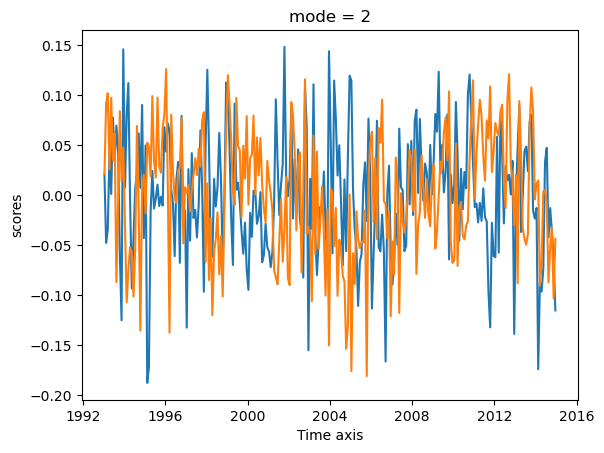

In [50]:
model.scores(normalized=True).isel(mode=0).plot()
model.scores(normalized=True).isel(mode=1).plot()

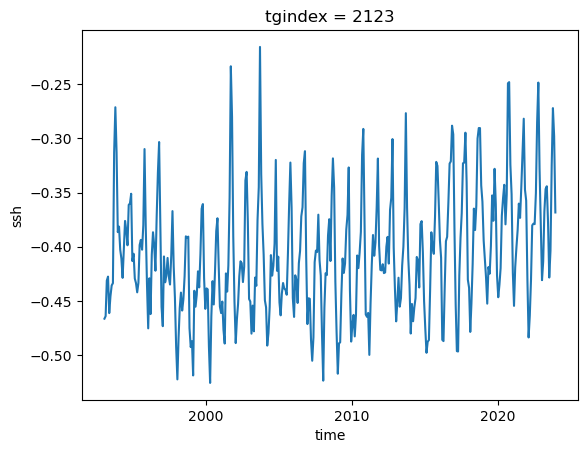

In [103]:
tgs_zos[4].isel(tgindex = 2).ssh.plot()

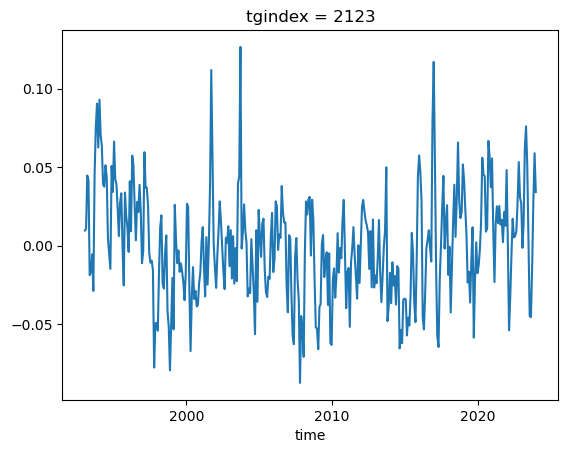

In [102]:
tgs_anom[4].isel(tgindex = 2).plot()